# Cross-Lingual Transferability of Voice Analysis Models: a Parkinson's Disease Case Study

## Preliminaries

### Imports

In [1]:
from typing import Tuple, List, Dict, Union, Optional

In [2]:
import os
from ast import literal_eval
import datetime

In [3]:
import numpy as np
import pandas as pd
import librosa

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

### Constants

In [5]:
EN_DATA_DIR: str = '../resources/data/preprocessed/en'
EN_METADATA_FILE: str = '../resources/data/preprocessed/en/metadata.csv'
TE_DATA_DIR: str = '../resources/data/preprocessed/te'
TE_METADATA_FILE: str = '../resources/data/preprocessed/te/metadata.csv'

In [6]:
EN_TO_TE_EXPERIMENTS_DIR: str = '../experiments/experiment_2023_02_03_10_55_53/'
TE_TO_EN_EXPERIMENTS_DIR: str = '../experiments/experiment_2023_02_03_20_46_40/'

In [7]:
OUT_DIR_PATH: str = '../experiments/results'
if not os.path.exists(OUT_DIR_PATH):
    os.mkdir(OUT_DIR_PATH)

In [8]:
LABEL_MAPPING: Dict[str, str] = {
    'healthy': 'Healthy conditions',
    'unhealthy': 'Parkinson\'s disease'
}
FEATURES_MAPPING: Dict[str, str] = {
    'spectral': 'Prosodic and Acoustic',
    'vggish': 'VGGish',
    'soundnet': 'SoundNet',
    'wav2vec': 'Wav2Vec 2.0'
}
POOLING_MAPPING: Dict[str, str] = {
    'avg': 'Avg. pooling',
    'max': 'Max pooling',
    'flatten': 'Flattening'
}
ADAPTATION_MAPPING: Dict[bool, str] = {
    False: 'None',
    True: 'Deep CORAL'  # 'CORrelation ALignment (CORAL)'
}
DATA_MAPPING: Dict[str, str] = {
    'src': 'Source data (test split)',
    'tgt': 'Target data'
}
METRICS_MAPPING: Dict[str, str] = {
    'accuracy': 'Accuracy',
    'precision': 'Precision',
    'recall': 'Recall',
    'fscore': '$F_1$-score',
    'specificity': 'Specificity',
    'roc_auc': 'ROC AUC',
    'support': 'Support',
    'fpr': 'False positives rate',
    'tpr': 'True postives rate',
    'roc_thresholds': 'Threshold (from ROC curve)',
    'precisions': 'Precision score',
    'recalls': 'Recall score',
    'pr_rc_thresholds': 'Threshold (from precision-recall curve)',
    'confusion_matrix': 'Confusion matrix'
}

In [9]:
METRICS = ['Accuracy', 'Precision', 'Recall', '$F_1$-score', 'Specificity', 'ROC AUC']
ROC = ['False positives rate', 'True postives rate', 'Threshold (from ROC curve)']
PRC_REC = ['Precision score', 'Recall score', 'Threshold (from precision-recall curve)']
CONF_MAT = ['Confusion matrix']

In [10]:
DF_COLUMNS: List[str] = ['Input features', 'Pooling approach', 'Domain adaptation', 'Data set', 'Metric', 'Value']

### Utility function(s)

In [11]:
def get_duration(path: str) -> Optional[float]:
    if os.path.exists(path):
        return librosa.get_duration(filename=path)
    else:
        return None

In [12]:
def convert_series(raw_series: pd.Series) -> Tuple[
    str, str, str, str, str, Union[float, int, List[float], List[List[int]]]
]:
    feature: str = FEATURES_MAPPING[raw_series['feature']]
    pooling: str = POOLING_MAPPING[raw_series['pooling']]
    adaptation: str = ADAPTATION_MAPPING[raw_series['adaptation']]
    data: str = DATA_MAPPING[raw_series['data_set']]
    metric: str = METRICS_MAPPING[raw_series['metric']]
    try:
        value = literal_eval(raw_series['value'])
    except:
        value = None
    
    return feature, pooling, adaptation, data, metric, value

In [13]:
def convert_results_df(raw_df: pd.DataFrame) -> pd.DataFrame:
    df: pd.DataFrame = pd.DataFrame(
        [convert_series(row) for _, row in raw_df.iterrows()], columns=DF_COLUMNS
    )

    return df

## Data

Load data

In [14]:
df_en_metadata: pd.DataFrame = pd.read_csv(EN_METADATA_FILE, )
df_en_metadata['Language'] = 'English'
df_en_metadata['Label'] = df_en_metadata.apply(lambda r: LABEL_MAPPING[r['label']], axis=1)

df_en_metadata.sample(10)

,file_name,label,original_file_name,start_time,end_time,Language,Label
108,ReadText_HC_ID22_hc_0_0_0_005.wav,healthy,ReadText/HC/ID22_hc_0_0_0.wav,00:02:30.000,00:02:45.000,English,Healthy conditions
142,ReadText_HC_ID28_hc_0_0_0_007.wav,healthy,ReadText/HC/ID28_hc_0_0_0.wav,00:02:10.000,00:02:23.000,English,Healthy conditions
435,SpontaneousDialogue_PD_ID24_pd_2_0_0_003.wav,unhealthy,SpontaneousDialogue/PD/ID24_pd_2_0_0.wav,00:01:27.000,00:01:33.000,English,Parkinson's disease
148,ReadText_HC_ID31_hc_0_1_1_005.wav,healthy,ReadText/HC/ID31_hc_0_1_1.wav,00:02:01.000,00:02:09.000,English,Healthy conditions
354,SpontaneousDialogue_HC_ID21_hc_0_0_0_001.wav,healthy,SpontaneousDialogue/HC/ID21_hc_0_0_0.wav,00:00:26.000,00:00:40.000,English,Healthy conditions
389,SpontaneousDialogue_PD_ID02_pd_2_0_0_001.wav,unhealthy,SpontaneousDialogue/PD/ID02_pd_2_0_0.wav,00:00:46.000,00:00:58.000,English,Parkinson's disease
4,ReadText_HC_ID00_hc_0_0_0_004.wav,healthy,ReadText/HC/ID00_hc_0_0_0.wav,00:00:59.000,00:01:13.000,English,Healthy conditions
237,ReadText_PD_ID20_pd_3_0_1_007.wav,unhealthy,ReadText/PD/ID20_pd_3_0_1.wav,00:01:53.000,00:02:03.000,English,Parkinson's disease
382,SpontaneousDialogue_HC_ID31_hc_0_1_1_000.wav,healthy,SpontaneousDialogue/HC/ID31_hc_0_1_1.wav,00:00:19.000,00:00:25.000,English,Healthy conditions
381,SpontaneousDialogue_HC_ID28_hc_0_0_0_003.wav,healthy,SpontaneousDialogue/HC/ID28_hc_0_0_0.wav,00:01:27.000,00:01:36.000,English,Healthy conditions


In [15]:
df_te_metadata: pd.DataFrame = pd.read_csv(TE_METADATA_FILE)
df_te_metadata['Language'] = 'Telugu'
df_te_metadata['Label'] = df_te_metadata.apply(lambda r: LABEL_MAPPING[r['label']], axis=1)

df_te_metadata.sample(10)

,file_name,label,original_file_name,start_time,end_time,Language,Label
14,AUD-20210601-WA0018_004.wav,unhealthy,AUD-20210601-WA0018.wav,00:00:51.000,00:01:00.000,Telugu,Parkinson's disease
268,te_in_male_tem_09015_00261471872_000.wav,healthy,te_in_male/tem_09015_00261471872.wav,NaN,NaN,Telugu,Healthy conditions
275,te_in_male_tem_09222_02094612080_000.wav,healthy,te_in_male/tem_09222_02094612080.wav,NaN,NaN,Telugu,Healthy conditions
65,krishnaiah_001.wav,unhealthy,krishnaiah.wav,00:00:13.000,00:00:20.000,Telugu,Parkinson's disease
11,AUD-20210601-WA0018_001.wav,unhealthy,AUD-20210601-WA0018.wav,00:00:13.000,00:00:25.000,Telugu,Parkinson's disease
136,te_in_female_tef_05691_01425196827_000.wav,healthy,te_in_female/tef_05691_01425196827.wav,NaN,NaN,Telugu,Healthy conditions
231,te_in_male_tem_03338_01765466706_000.wav,healthy,te_in_male/tem_03338_01765466706.wav,NaN,NaN,Telugu,Healthy conditions
159,te_in_female_tef_06928_00862600646_000.wav,healthy,te_in_female/tef_06928_00862600646.wav,NaN,NaN,Telugu,Healthy conditions
225,te_in_male_tem_03338_00681547785_000.wav,healthy,te_in_male/tem_03338_00681547785.wav,NaN,NaN,Telugu,Healthy conditions
246,te_in_male_tem_05425_01377983397_000.wav,healthy,te_in_male/tem_05425_01377983397.wav,NaN,NaN,Telugu,Healthy conditions


In [16]:
df_metadata = pd.concat([df_en_metadata, df_te_metadata]).reset_index()

df_metadata.sample(10)

,index,file_name,label,original_file_name,start_time,end_time,Language,Label
655,190,te_in_male_tem_00682_00025627195_000.wav,healthy,te_in_male/tem_00682_00025627195.wav,NaN,NaN,Telugu,Healthy conditions
611,146,te_in_female_tef_06566_00659178421_000.wav,healthy,te_in_female/tef_06566_00659178421.wav,NaN,NaN,Telugu,Healthy conditions
311,311,SpontaneousDialogue_HC_ID08_hc_0_0_0_003.wav,healthy,SpontaneousDialogue/HC/ID08_hc_0_0_0.wav,00:00:59.000,00:01:08.000,English,Healthy conditions
366,366,SpontaneousDialogue_HC_ID23_hc_0_0_0_004.wav,healthy,SpontaneousDialogue/HC/ID23_hc_0_0_0.wav,00:01:35.000,00:01:46.000,English,Healthy conditions
21,21,ReadText_HC_ID03_hc_0_0_0_002.wav,healthy,ReadText/HC/ID03_hc_0_0_0.wav,00:00:59.000,00:01:10.000,English,Healthy conditions
669,204,te_in_male_tem_02769_00733971605_000.wav,healthy,te_in_male/tem_02769_00733971605.wav,NaN,NaN,Telugu,Healthy conditions
32,32,ReadText_HC_ID08_hc_0_0_0_001.wav,healthy,ReadText/HC/ID08_hc_0_0_0.wav,00:00:42.000,00:00:51.000,English,Healthy conditions
532,67,lakshmi pd ai_000.wav,unhealthy,lakshmi pd ai.wav,00:00:00.000,00:00:09.000,Telugu,Parkinson's disease
554,89,te_in_female_tef_01908_00287699580_000.wav,healthy,te_in_female/tef_01908_00287699580.wav,NaN,NaN,Telugu,Healthy conditions
368,368,SpontaneousDialogue_HC_ID25_hc_0_0_0_001.wav,healthy,SpontaneousDialogue/HC/ID25_hc_0_0_0.wav,00:01:20.000,00:01:27.000,English,Healthy conditions


Distribution of duration (in seconds) of audio files

In [17]:
df_metadata['Duration [s]'] = df_metadata.apply(
    lambda r: get_duration(os.path.join(EN_DATA_DIR if r['Language'] == 'English' else TE_DATA_DIR, r['file_name'])), axis=1
)
df_metadata.sample(10)

,index,file_name,label,original_file_name,start_time,end_time,Language,Label,Duration [s]
596,131,te_in_female_tef_05484_01413183986_000.wav,healthy,te_in_female/tef_05484_01413183986.wav,NaN,NaN,Telugu,Healthy conditions,4.010667
529,64,krishnaiah_000.wav,unhealthy,krishnaiah.wav,00:00:00.000,00:00:11.000,Telugu,Parkinson's disease,11.008000
275,275,ReadText_PD_ID33_pd_3_2_2_003.wav,unhealthy,ReadText/PD/ID33_pd_3_2_2.wav,00:01:00.000,00:01:07.000,English,Parkinson's disease,6.995238
580,115,te_in_female_tef_04261_01626602277_000.wav,healthy,te_in_female/tef_04261_01626602277.wav,NaN,NaN,Telugu,Healthy conditions,3.669333
168,168,ReadText_PD_ID02_pd_2_0_0_001.wav,unhealthy,ReadText/PD/ID02_pd_2_0_0.wav,00:00:34.000,00:00:43.000,English,Parkinson's disease,9.007143
289,289,SpontaneousDialogue_HC_ID00_hc_0_0_0_000.wav,healthy,SpontaneousDialogue/HC/ID00_hc_0_0_0.wav,00:00:35.000,00:00:49.000,English,Healthy conditions,14.021429
462,462,SpontaneousDialogue_PD_ID33_pd_3_2_2_005.wav,unhealthy,SpontaneousDialogue/PD/ID33_pd_3_2_2.wav,00:01:35.000,00:01:48.000,English,Parkinson's disease,13.000000
243,243,ReadText_PD_ID24_pd_2_0_0_004.wav,unhealthy,ReadText/PD/ID24_pd_2_0_0.wav,00:01:33.000,00:01:45.000,English,Parkinson's disease,12.009524
333,333,SpontaneousDialogue_HC_ID12_hc_0_0_0_003.wav,healthy,SpontaneousDialogue/HC/ID12_hc_0_0_0.wav,00:01:11.000,00:01:21.000,English,Healthy conditions,9.997619
475,10,AUD-20210601-WA0018_000.wav,unhealthy,AUD-20210601-WA0018.wav,00:00:00.000,00:00:13.000,Telugu,Parkinson's disease,13.013333


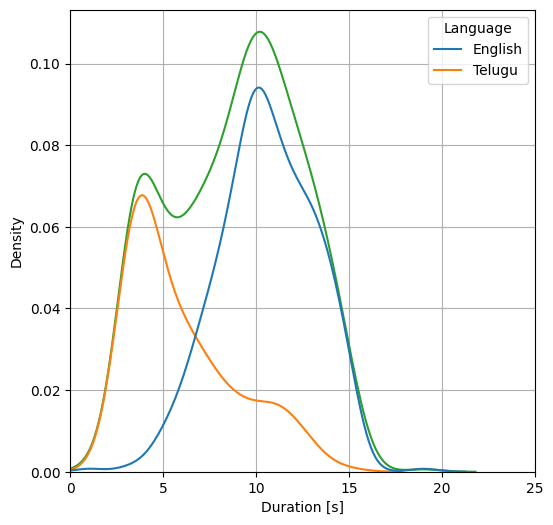

In [18]:
fig = plt.figure(figsize=(6, 6))

sns.kdeplot(data=df_metadata, x='Duration [s]', color='tab:green')
sns.kdeplot(data=df_metadata, x='Duration [s]', hue='Language' , color=['tab:red', 'tab:green'])
plt.xlabel('Duration [s]')
plt.xlim(0, 25)
plt.grid()

plt.show()

In [19]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'dist_duration.pdf'))

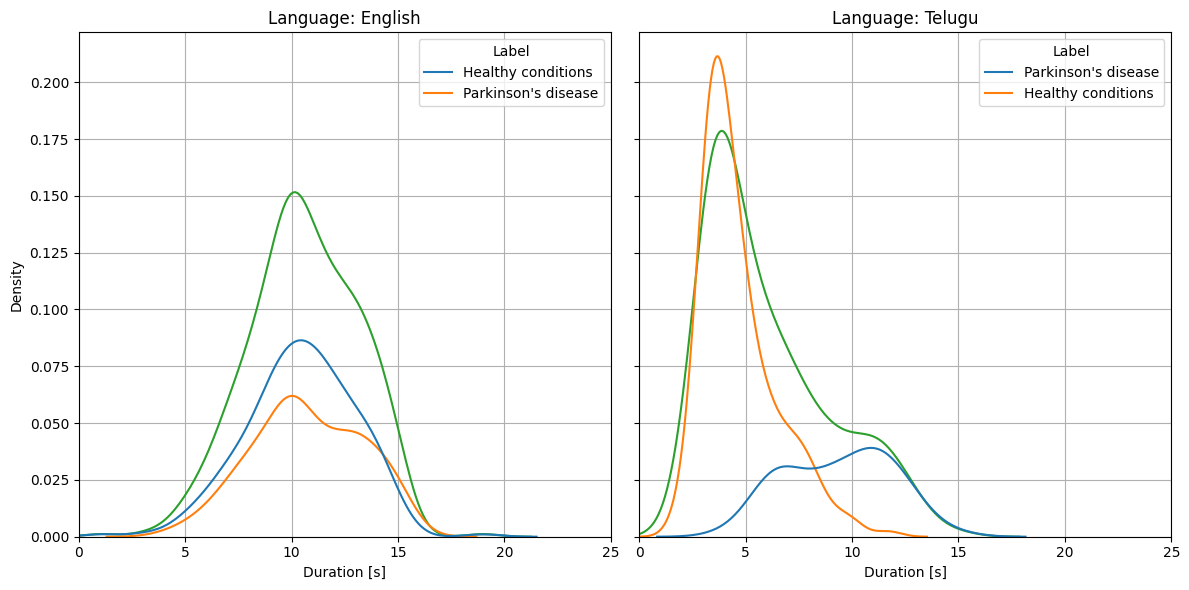

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=True)

for i, (language) in enumerate(['English', 'Telugu']):
    sns.kdeplot(data=df_metadata[df_metadata['Language'] == language], x='Duration [s]', color='tab:green', ax=axes[i])
    sns.kdeplot(
        data=df_metadata[df_metadata['Language'] == language],
        x='Duration [s]',
        hue='Label',
        color=['tab:red', 'tab:blue'],
        ax=axes[i]
    )
    plt.xlabel('Duration [s]')
    axes[i].set_title(f'Language: {language}')
    axes[i].set_xlabel('Duration [s]')
    axes[i].grid()
    axes[i].set_xlim(0, 25)

plt.tight_layout()
plt.show()


In [21]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'dist_duration_lang.pdf'))

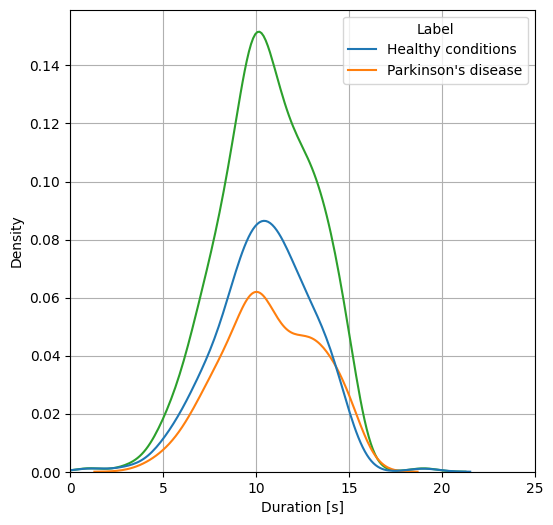

In [22]:
fig = plt.figure(figsize=(6, 6))

sns.kdeplot(data=df_metadata[df_metadata['Language'] == 'English'], x='Duration [s]', color='tab:green')
sns.kdeplot(data=df_metadata[df_metadata['Language'] == 'English'], x='Duration [s]', hue='Label' , color=['tab:red', 'tab:blue'])
plt.xlabel('Duration [s]')
plt.xlim(0, 25)
plt.grid()

plt.show()

In [23]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'dist_duration_en.pdf'))

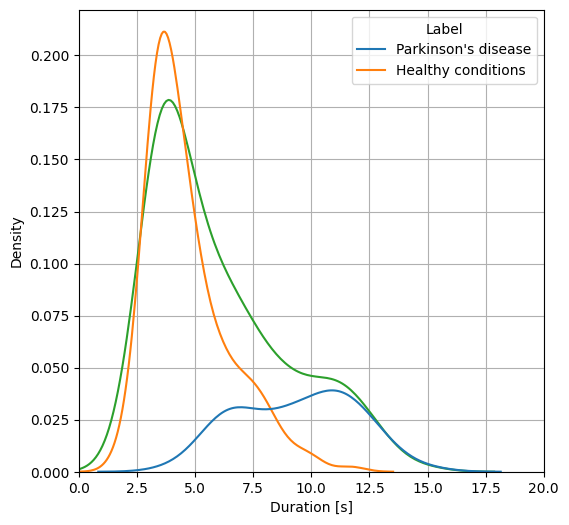

In [24]:
fig = plt.figure(figsize=(6, 6))

sns.kdeplot(data=df_metadata[df_metadata['Language'] == 'Telugu'], x='Duration [s]', color='tab:green')
sns.kdeplot(data=df_metadata[df_metadata['Language'] == 'Telugu'], x='Duration [s]', hue='Label' , color=['tab:red', 'tab:green'])
plt.xlabel('Duration [s]')
plt.xlim(0, 20)
plt.grid()

plt.show()

In [25]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'dist_duration_te.pdf'))

Cumulative durations

In [26]:
print(f"Total time [s]:                        {datetime.timedelta(seconds=df_metadata['Duration [s]'].sum())}")
print(f"Healthy patients time [s]:             {datetime.timedelta(seconds=df_metadata[df_metadata['Label'] == 'Healthy conditions']['Duration [s]'].sum())}")
print(f"Parkinson's disease patients time [s]: {datetime.timedelta(seconds=df_metadata[df_metadata['Label'] != 'Healthy conditions']['Duration [s]'].sum())}")

Total time [s]:                        1:49:14.816667
Healthy patients time [s]:             1:00:57.694095
Parkinson's disease patients time [s]: 0:48:17.122571


In [27]:
for language in ['English', 'Telugu']:
    print(language)
    print(f"Total time [s]:                        {datetime.timedelta(seconds=df_metadata[df_metadata['Language'] == language]['Duration [s]'].sum())}")
    print(f"Healthy patients time [s]:             {datetime.timedelta(seconds=df_metadata[(df_metadata['Label'] == 'Healthy conditions') & (df_metadata['Language'] == language)]['Duration [s]'].sum())}")
    print(f"Parkinson's disease patients time [s]: {datetime.timedelta(seconds=df_metadata[(df_metadata['Label'] != 'Healthy conditions') & (df_metadata['Language'] == language)]['Duration [s]'].sum())}")
    print('\n')

English
Total time [s]:                        1:21:03.083333
Healthy patients time [s]:             0:45:25.171429
Parkinson's disease patients time [s]: 0:35:37.911905


Telugu
Total time [s]:                        0:28:11.733333
Healthy patients time [s]:             0:15:32.522667
Parkinson's disease patients time [s]: 0:12:39.210667




## Results
Load DataFrames with results

In [28]:
df_en_to_te: pd.DataFrame = pd.read_csv(os.path.join(EN_TO_TE_EXPERIMENTS_DIR, 'scores.csv'))
df_en_to_te = convert_results_df(df_en_to_te)

In [29]:
df_te_to_en = pd.read_csv(os.path.join(TE_TO_EN_EXPERIMENTS_DIR, 'scores.csv'))
df_te_to_en = convert_results_df(df_te_to_en)
df_te_to_en.sample(10)

,Input features,Pooling approach,Domain adaptation,Data set,Metric,Value
328,VGGish,Flattening,Deep CORAL,Target data,ROC AUC,0.69413
11,Prosodic and Acoustic,Avg. pooling,None,Source data (test split),Recall score,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
257,VGGish,Max pooling,Deep CORAL,Source data (test split),Specificity,0.935484
284,VGGish,Flattening,None,Source data (test split),Support,None
137,Prosodic and Acoustic,Flattening,None,Target data,Recall score,"[1.0, 0.998371335504886, 0.996742671009772, 0...."
656,Wav2Vec 2.0,Flattening,Deep CORAL,Source data (test split),Threshold (from precision-recall curve),"[0.0006381010171025991, 0.000950913003180176, ..."
360,SoundNet,Avg. pooling,None,Target data,Precision score,"[0.4400311526479751, 0.4403741231488698, 0.440..."
72,Prosodic and Acoustic,Max pooling,None,Target data,Recall,0.576271
45,Prosodic and Acoustic,Avg. pooling,Deep CORAL,Target data,$F_1$-score,0.516812
573,Wav2Vec 2.0,Max pooling,None,Source data (test split),Confusion matrix,"[[71, 0], [0, 70]]"


### Detection in English

In [30]:
df = df_en_to_te[
    (df_en_to_te['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_en_to_te['Data set'] == DATA_MAPPING['src']) & df_en_to_te['Metric'].isin(METRICS)]
# print(df)

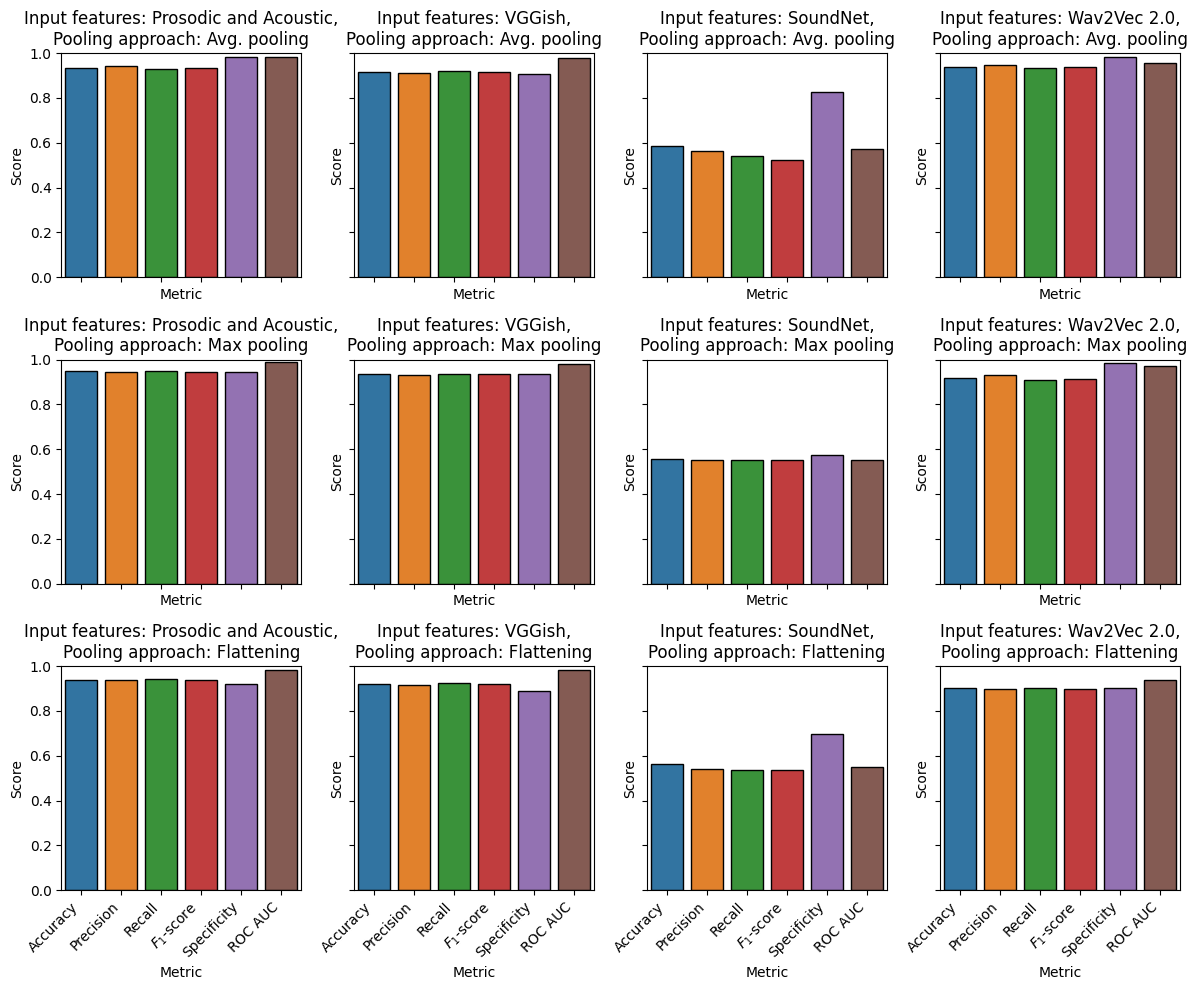

In [31]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        sns.barplot(
            data=df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling)],
            x='Metric',
            y='Value',
            ax=axes[i][j],
            linewidth=1.,
            edgecolor='0',
            order=list(METRICS)
        )
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        axes[i][j].set_xlabel('Metric')
        axes[i][j].set_ylabel('Score')
        axes[i][j].set_ylim(0.0, 1.0)
        # axes[i][j].grid()
        axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [32]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_cls_results.pdf'))

#### ROC curve

In [33]:
df = df_en_to_te[
    (df_en_to_te['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_en_to_te['Data set'] == DATA_MAPPING['src']) & (df_en_to_te['Metric'].isin(ROC))
]
df.sample(10)

,Input features,Pooling approach,Domain adaptation,Data set,Metric,Value
288,VGGish,Flattening,None,Source data (test split),True postives rate,"[0.0, 0.2878787878787879, 0.30303030303030304,..."
344,SoundNet,Avg. pooling,None,Source data (test split),True postives rate,"[0.0, 0.007633587786259542, 0.0229007633587786..."
401,SoundNet,Max pooling,None,Source data (test split),Threshold (from ROC curve),"[1.8445435762405396, 0.8445435762405396, 0.613..."
7,Prosodic and Acoustic,Avg. pooling,None,Source data (test split),False positives rate,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005..."
512,Wav2Vec 2.0,Avg. pooling,None,Source data (test split),True postives rate,"[0.0, 0.22818791946308725, 0.24161073825503357..."
457,SoundNet,Flattening,None,Source data (test split),Threshold (from ROC curve),"[1.6205294132232666, 0.6205293536186218, 0.618..."
121,Prosodic and Acoustic,Flattening,None,Source data (test split),Threshold (from ROC curve),"[2.0, 1.0, 0.9999999403953552, 0.9999998807907..."
567,Wav2Vec 2.0,Max pooling,None,Source data (test split),False positives rate,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
511,Wav2Vec 2.0,Avg. pooling,None,Source data (test split),False positives rate,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.005181347150259067..."
287,VGGish,Flattening,None,Source data (test split),False positives rate,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


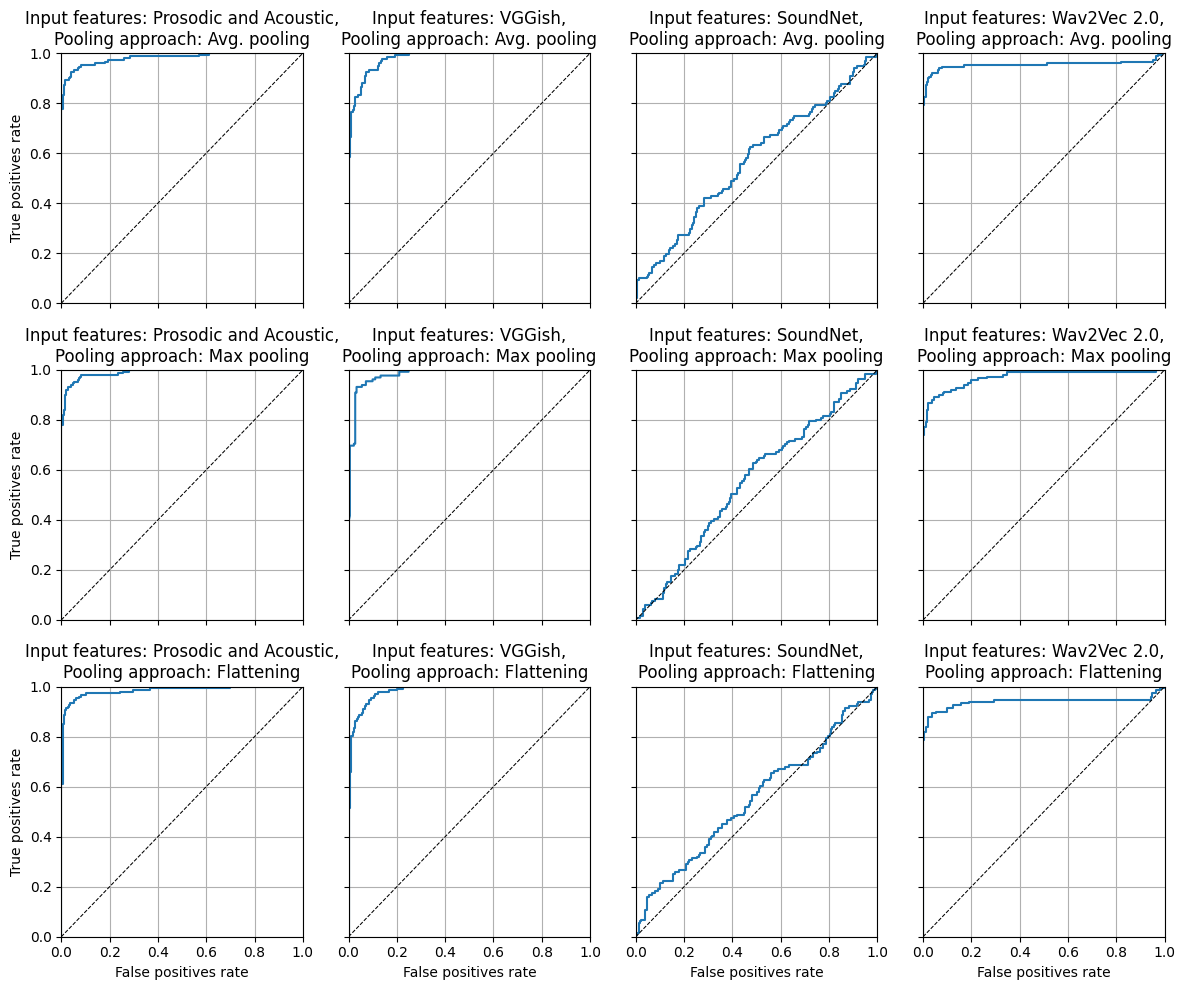

In [34]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        x = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'False positives rate')]['Value'].values[0]
        y = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'True postives rate')]['Value'].values[0]
        axes[i][j].plot(x, y)
        axes[i][j].plot([0, 1], [0, 1], '--k', linewidth=0.75)
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('False positives rate')
        if j == 0:
            axes[i][j].set_ylabel('True positives rate')
        axes[i][j].set_xlim(0.0, 1.0)
        axes[i][j].set_ylim(0.0, 1.0)
        axes[i][j].grid()
        # axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [35]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_roc_curve.pdf'))

#### Precision-recall curve

In [36]:
df = df_en_to_te[
    (df_en_to_te['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_en_to_te['Data set'] == DATA_MAPPING['src']) & (df_en_to_te['Metric'].isin(PRC_REC))
]
df.sample(10)

,Input features,Pooling approach,Domain adaptation,Data set,Metric,Value
346,SoundNet,Avg. pooling,None,Source data (test split),Precision score,"[0.4253246753246753, 0.42671009771986973, 0.42..."
458,SoundNet,Flattening,None,Source data (test split),Precision score,"[0.4253246753246753, 0.42671009771986973, 0.42..."
628,Wav2Vec 2.0,Flattening,None,Source data (test split),Threshold (from precision-recall curve),"[6.513247975658249e-34, 1.621019123004279e-30,..."
236,VGGish,Max pooling,None,Source data (test split),Threshold (from precision-recall curve),"[1.9204881012303138e-13, 2.0962300905508213e-1..."
290,VGGish,Flattening,None,Source data (test split),Precision score,"[0.4217252396166134, 0.4230769230769231, 0.424..."
123,Prosodic and Acoustic,Flattening,None,Source data (test split),Recall score,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
11,Prosodic and Acoustic,Avg. pooling,None,Source data (test split),Recall score,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
10,Prosodic and Acoustic,Avg. pooling,None,Source data (test split),Precision score,"[0.43567251461988304, 0.436950146627566, 0.438..."
459,SoundNet,Flattening,None,Source data (test split),Recall score,"[1.0, 1.0, 0.9923664122137404, 0.9923664122137..."
403,SoundNet,Max pooling,None,Source data (test split),Recall score,"[1.0, 0.9923664122137404, 0.9923664122137404, ..."


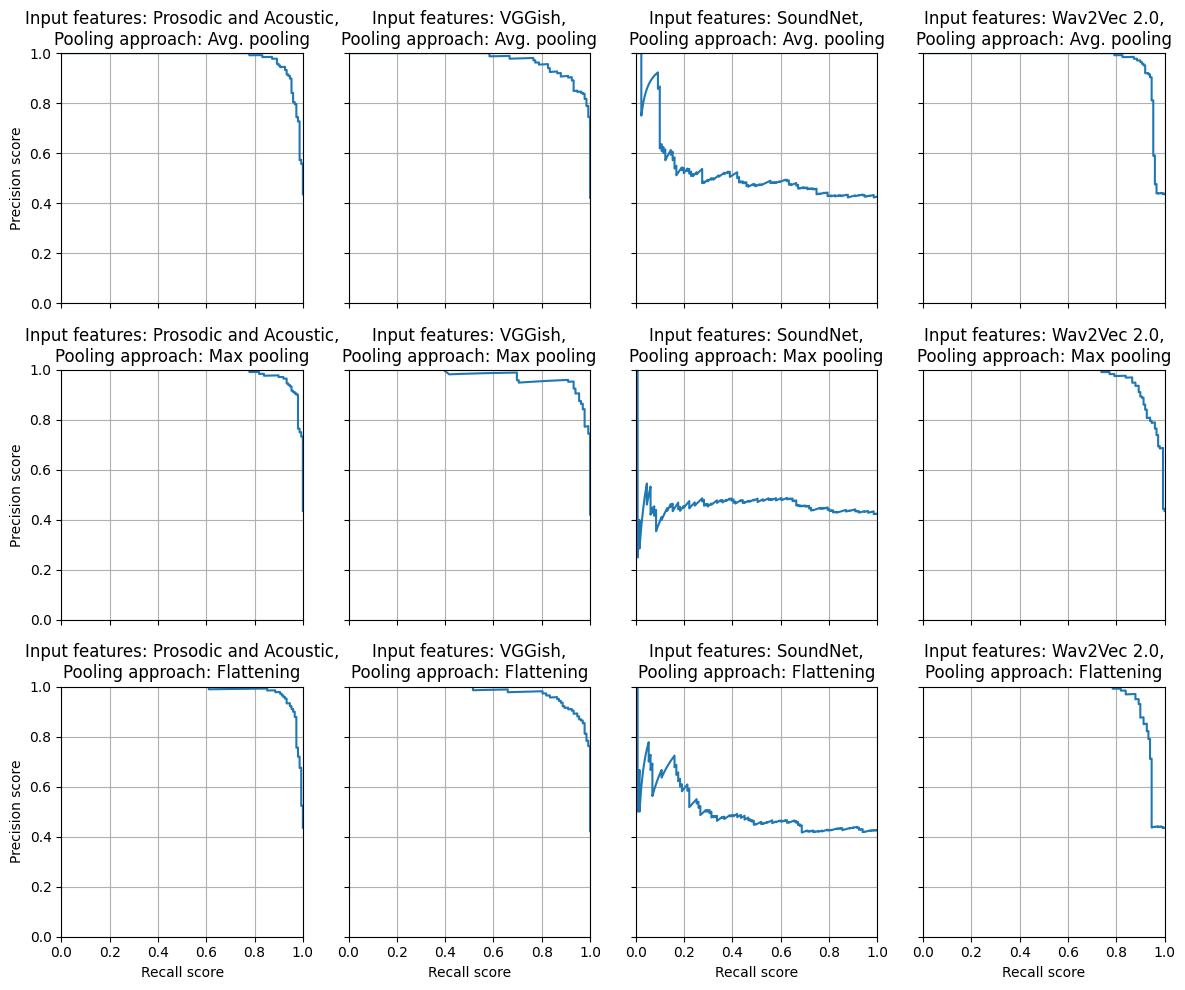

In [37]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        x = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Recall score')]['Value'].values[0]
        y = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Precision score')]['Value'].values[0]
        axes[i][j].plot(x, y)
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Recall score')
        if j == 0:
            axes[i][j].set_ylabel('Precision score')
        axes[i][j].set_xlim(0.0, 1.0)
        axes[i][j].set_ylim(0.0, 1.0)
        axes[i][j].grid()
        # axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [38]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_pr_curve.pdf'))

#### Confusion matrix

In [39]:
df = df_en_to_te[
    (df_en_to_te['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_en_to_te['Data set'] == DATA_MAPPING['src']) & (df_en_to_te['Metric'].isin(CONF_MAT))
]
df.sample(10)

,Input features,Pooling approach,Domain adaptation,Data set,Metric,Value
69,Prosodic and Acoustic,Max pooling,None,Source data (test split),Confusion matrix,"[[182, 11], [7, 142]]"
13,Prosodic and Acoustic,Avg. pooling,None,Source data (test split),Confusion matrix,"[[190, 3], [19, 130]]"
405,SoundNet,Max pooling,None,Source data (test split),Confusion matrix,"[[102, 75], [62, 69]]"
181,VGGish,Avg. pooling,None,Source data (test split),Confusion matrix,"[[164, 17], [9, 123]]"
125,Prosodic and Acoustic,Flattening,None,Source data (test split),Confusion matrix,"[[178, 15], [6, 143]]"
349,SoundNet,Avg. pooling,None,Source data (test split),Confusion matrix,"[[146, 31], [97, 34]]"
293,VGGish,Flattening,None,Source data (test split),Confusion matrix,"[[161, 20], [5, 127]]"
517,Wav2Vec 2.0,Avg. pooling,None,Source data (test split),Confusion matrix,"[[190, 3], [18, 131]]"
461,SoundNet,Flattening,None,Source data (test split),Confusion matrix,"[[123, 54], [81, 50]]"
237,VGGish,Max pooling,None,Source data (test split),Confusion matrix,"[[169, 12], [8, 124]]"


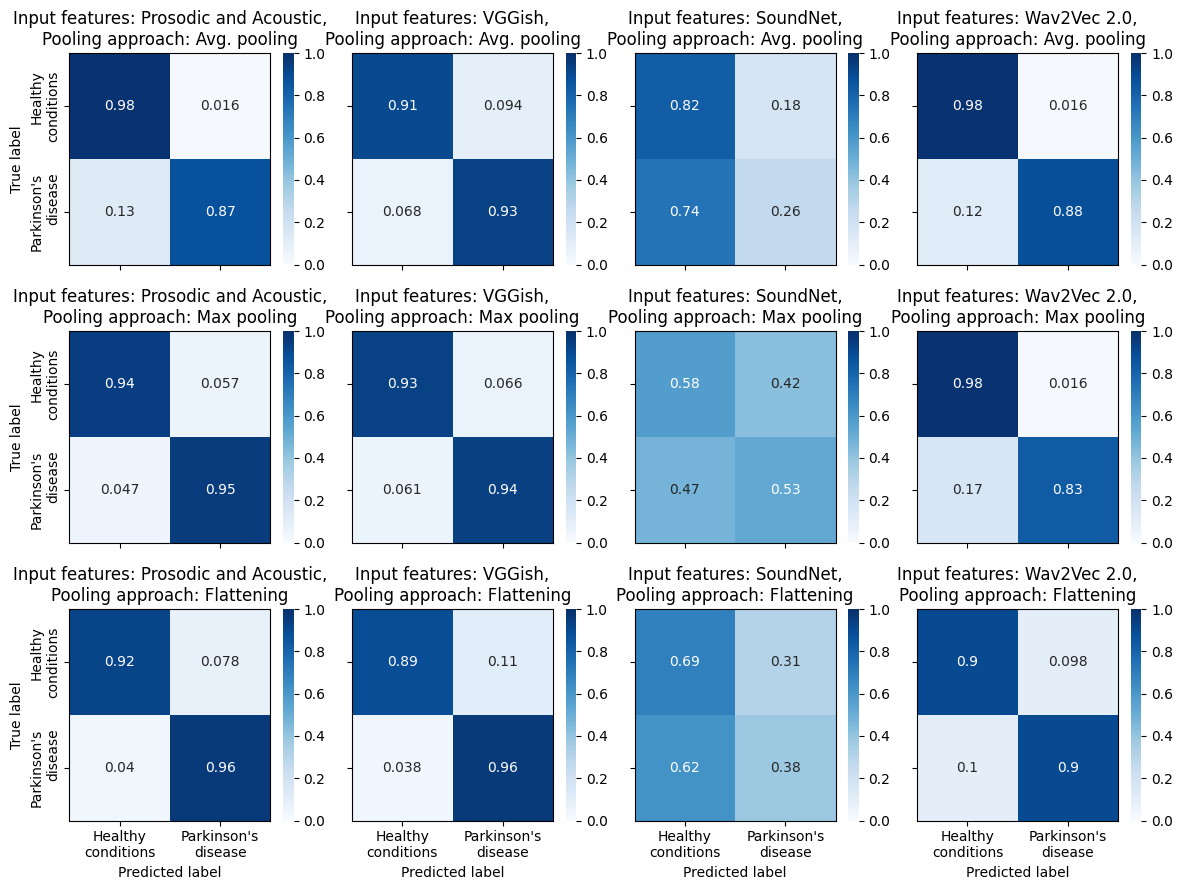

In [40]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 9),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        mat = np.array(df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Confusion matrix')]['Value'].values[0]).astype(float)
        mat /= mat.sum(1).reshape(-1, 1)
        
        hmap = sns.heatmap(
            mat, 
            cmap=plt.colormaps['Blues'], 
            vmin=0.0, 
            vmax=1.0, 
            ax=axes[i][j], 
            annot=True, 
            linecolor='0', 
            xticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'], 
            yticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'],
        )
        sns.despine(ax=axes[i][j], top=False, right=False, left=False, bottom=False)
        sns.despine(ax=hmap, top=False, right=False, left=False, bottom=False)
        # fig.colorbar(mappable=mat, ax=axes[i][j])
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Predicted label')
        if j == 0:
            axes[i][j].set_ylabel('True label')
plt.tight_layout()
plt.show()

In [41]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_cm.pdf'))

### Transferring from English to Hindi

In [42]:
df_all = df_en_to_te[
    (df_en_to_te['Data set'] == DATA_MAPPING['tgt']) & (df_en_to_te['Metric'].isin(METRICS))]
# print(df_no_ad)

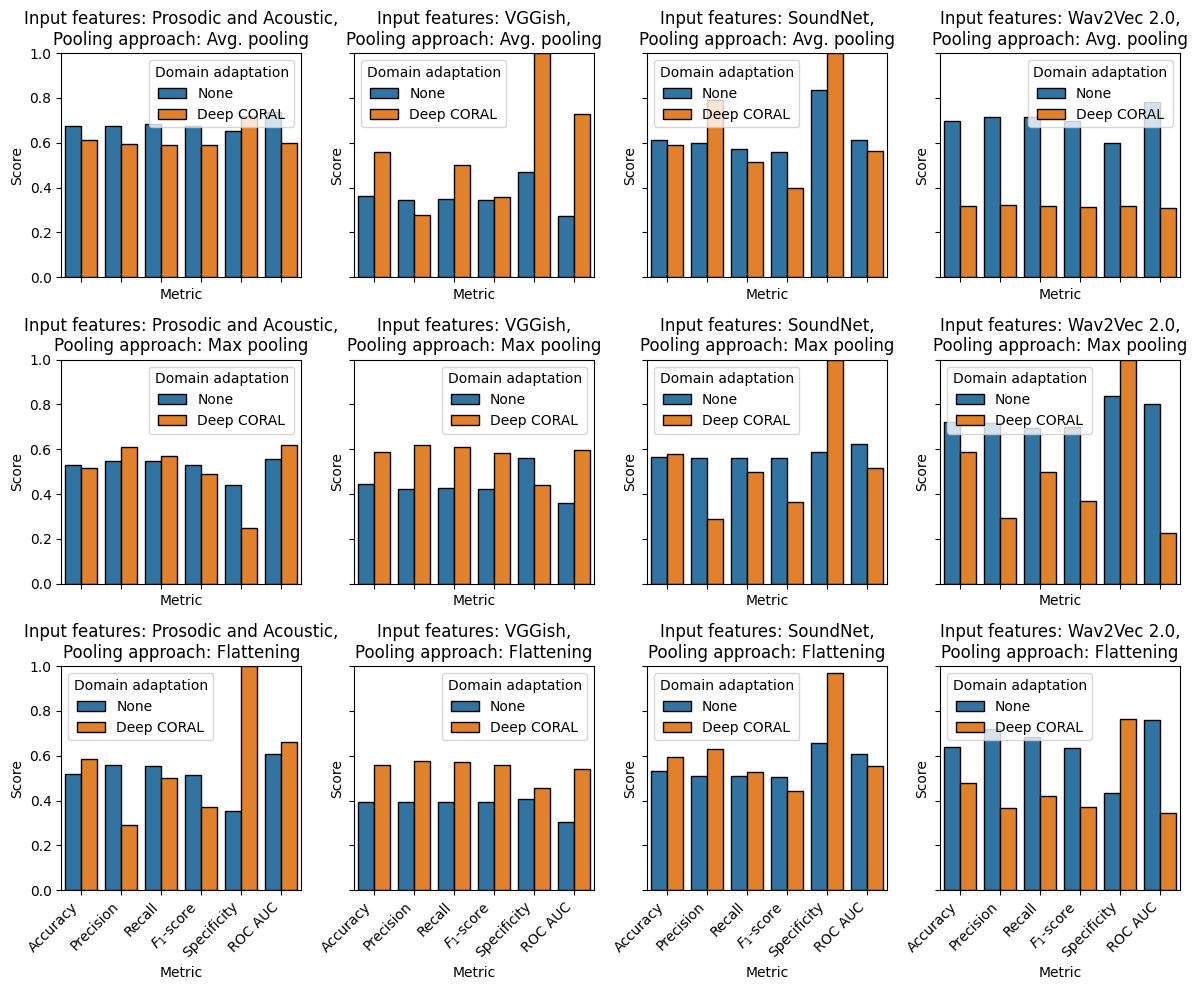

In [43]:
fig, axes = plt.subplots(
        nrows=len(df_all['Pooling approach'].unique()),
        ncols=len(df_all['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )



for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        
        sns.barplot(
            data=df_all[(df_all['Input features'] == feature) & (df_all['Pooling approach'] == pooling)],
            x='Metric',
            y='Value',
            ax=axes[i][j],
            linewidth=1.,
            edgecolor='0',
            order=list(METRICS),
            hue='Domain adaptation'
        )
       
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        axes[i][j].set_xlabel('Metric')
        axes[i][j].set_ylabel('Score')
        axes[i][j].set_ylim(0.0, 1.0)
        # axes[i][j].grid()
        axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [44]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_to_te_results.pdf'))

### ROC curve

In [45]:
df = df_en_to_te[
    (df_en_to_te['Domain adaptation'] == ADAPTATION_MAPPING[True]) & (df_en_to_te['Data set'] == DATA_MAPPING['tgt']) & df_en_to_te['Metric'].isin(ROC)]
df_no_ad = df_en_to_te[
    (df_en_to_te['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_en_to_te['Data set'] == DATA_MAPPING['tgt']) & df_en_to_te['Metric'].isin(ROC)]
# print(df_no_ad)

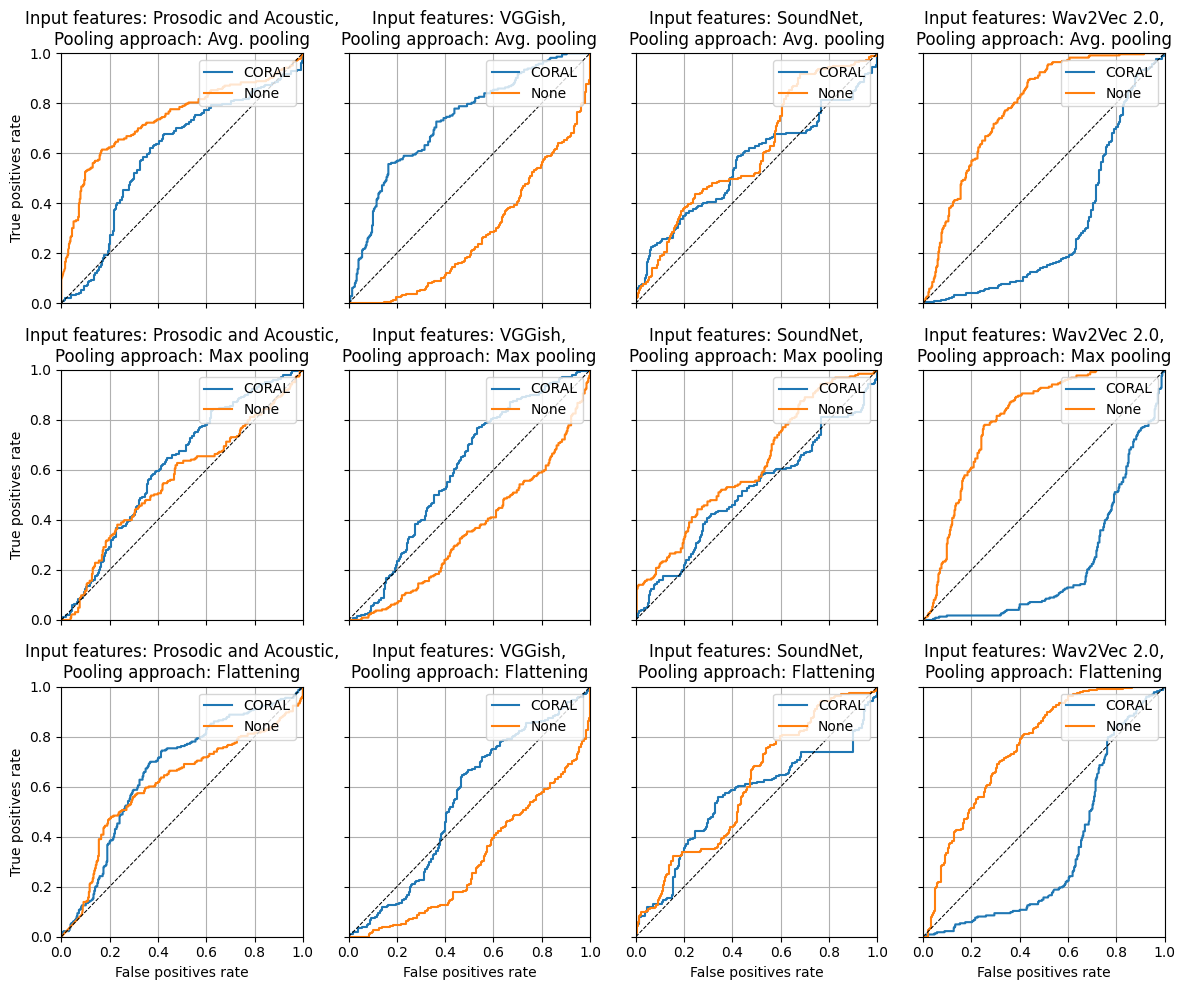

In [46]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        x = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'False positives rate')]['Value'].values[0]
        y = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'True postives rate')]['Value'].values[0]
        
        x_1 =  df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'False positives rate')]['Value'].values[0]
        y_1 =  df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'True postives rate')]['Value'].values[0]
        
        axes[i][j].plot(x, y, label='CORAL')
        axes[i][j].plot(x_1, y_1, label='None')
        axes[i][j].legend(loc='upper right')
        axes[i][j].plot([0, 1], [0, 1], '--k', linewidth=0.75)
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('False positives rate')
        if j == 0:
            axes[i][j].set_ylabel('True positives rate')
        axes[i][j].set_xlim(0.0, 1.0)
        axes[i][j].set_ylim(0.0, 1.0)
        axes[i][j].grid()

        # axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [47]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_to_te_roc_curve.pdf'))

#### Precision-recall curve

In [48]:
df = df_en_to_te[
    (df_en_to_te['Domain adaptation'] == ADAPTATION_MAPPING[True]) & (df_en_to_te['Data set'] == DATA_MAPPING['tgt']) & df_en_to_te['Metric'].isin(PRC_REC)]
df_no_ad = df_en_to_te[
    (df_en_to_te['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_en_to_te['Data set'] == DATA_MAPPING['tgt']) & df_en_to_te['Metric'].isin(PRC_REC)]
df_all = df_en_to_te[
    (df_en_to_te['Data set'] == DATA_MAPPING['tgt']) & (df_en_to_te['Metric'].isin(PRC_REC))]
# print(df_no_ad)

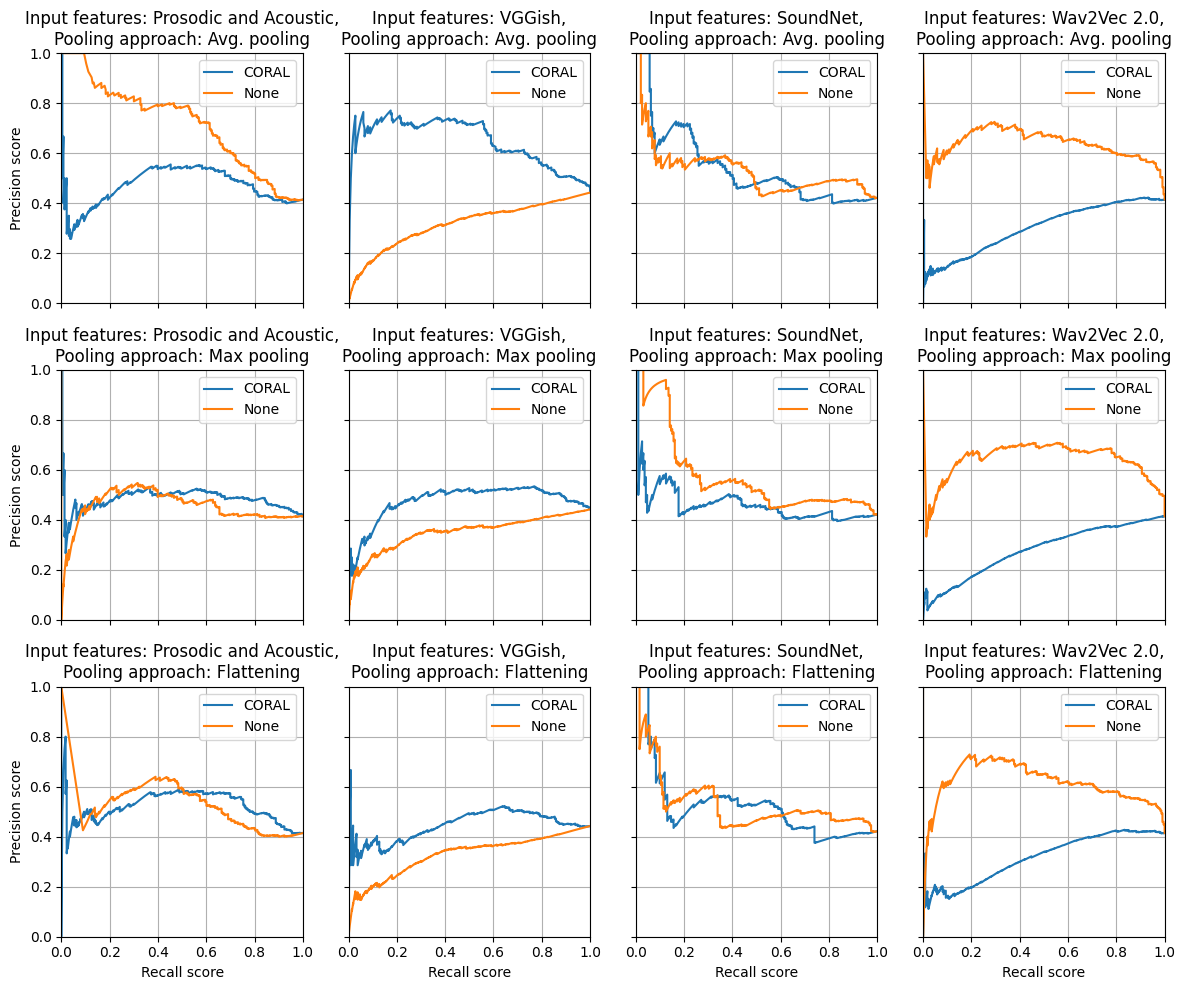

In [49]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        x = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Recall score')]['Value'].values[0]
        y = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Precision score')]['Value'].values[0]
        
        x_1 =  df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'Recall score')]['Value'].values[0]
        y_1 =  df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'Precision score')]['Value'].values[0]
        
        axes[i][j].plot(x, y, label='CORAL')
        axes[i][j].plot(x_1, y_1, label='None')
        axes[i][j].legend(loc='upper right')
        # axes[i][j].plot([0, 1], [0, 1], '--k', linewidth=0.75)
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Recall score')
        if j == 0:
            axes[i][j].set_ylabel('Precision score')
        axes[i][j].set_xlim(0.0, 1.0)
        axes[i][j].set_ylim(0.0, 1.0)
        axes[i][j].grid()

        # axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [50]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_to_te_pr_curve.pdf'))

#### Confusion matrix

In [51]:
df = df_en_to_te[
    (df_en_to_te['Domain adaptation'] == ADAPTATION_MAPPING[True]) & (df_en_to_te['Data set'] == DATA_MAPPING['tgt']) & df_en_to_te['Metric'].isin(CONF_MAT)]
df_no_ad = df_en_to_te[
    (df_en_to_te['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_en_to_te['Data set'] == DATA_MAPPING['tgt']) & df_en_to_te['Metric'].isin(CONF_MAT)]
df_all = df_en_to_te[
    (df_en_to_te['Data set'] == DATA_MAPPING['tgt']) & (df_en_to_te['Metric'].isin(CONF_MAT))]
# print(df_no_ad)

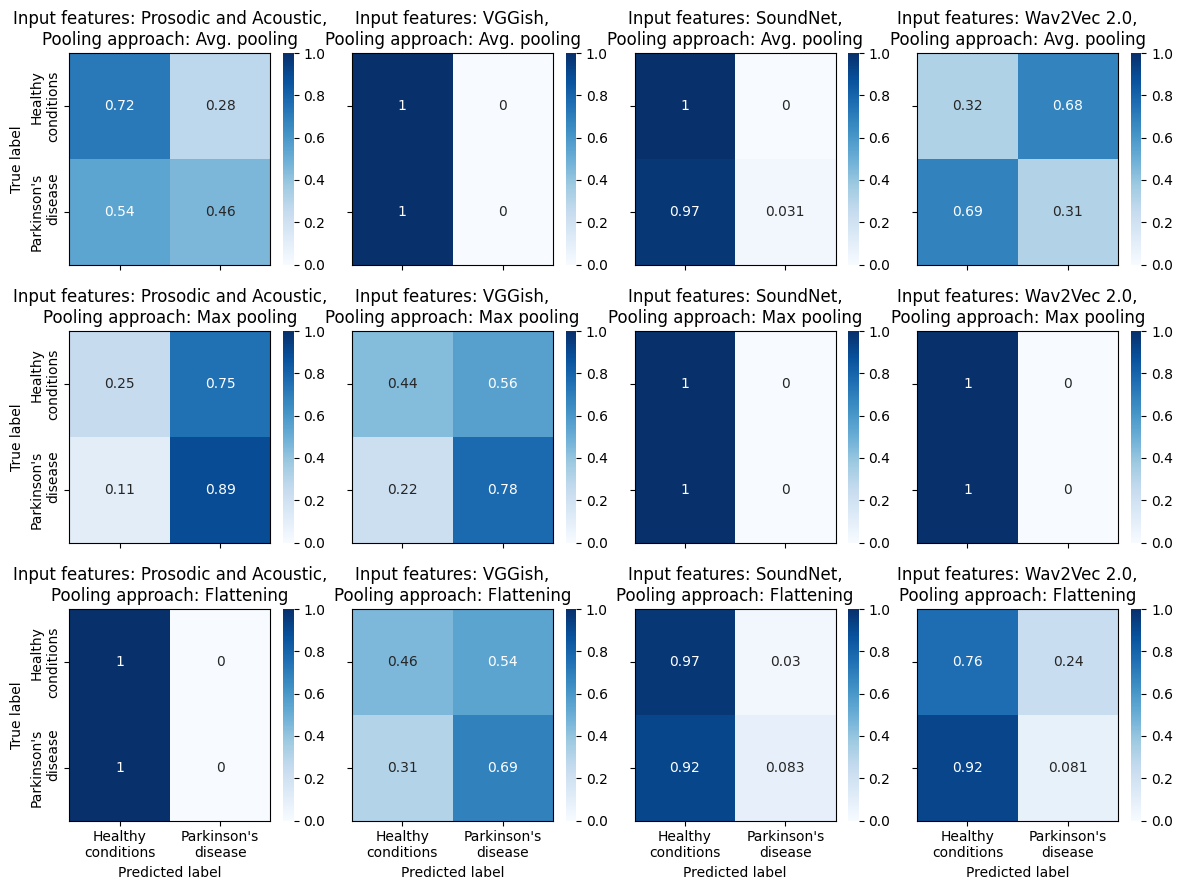

In [52]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 9),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        mat = np.array(df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Confusion matrix')]['Value'].values[0]).astype(float)
        mat /= mat.sum(1).reshape(-1, 1)
        
        hmap = sns.heatmap(
            mat, 
            cmap=plt.colormaps['Blues'], 
            vmin=0.0, 
            vmax=1.0, 
            ax=axes[i][j], 
            annot=True, 
            linecolor='0', 
            xticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'], 
            yticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'],
        )
        sns.despine(ax=axes[i][j], top=False, right=False, left=False, bottom=False)
        sns.despine(ax=hmap, top=False, right=False, left=False, bottom=False)
        # fig.colorbar(mappable=mat, ax=axes[i][j])
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Predicted label')
        if j == 0:
            axes[i][j].set_ylabel('True label')
plt.tight_layout()
plt.show()

In [53]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_to_te_with_adpt_cm.pdf'))

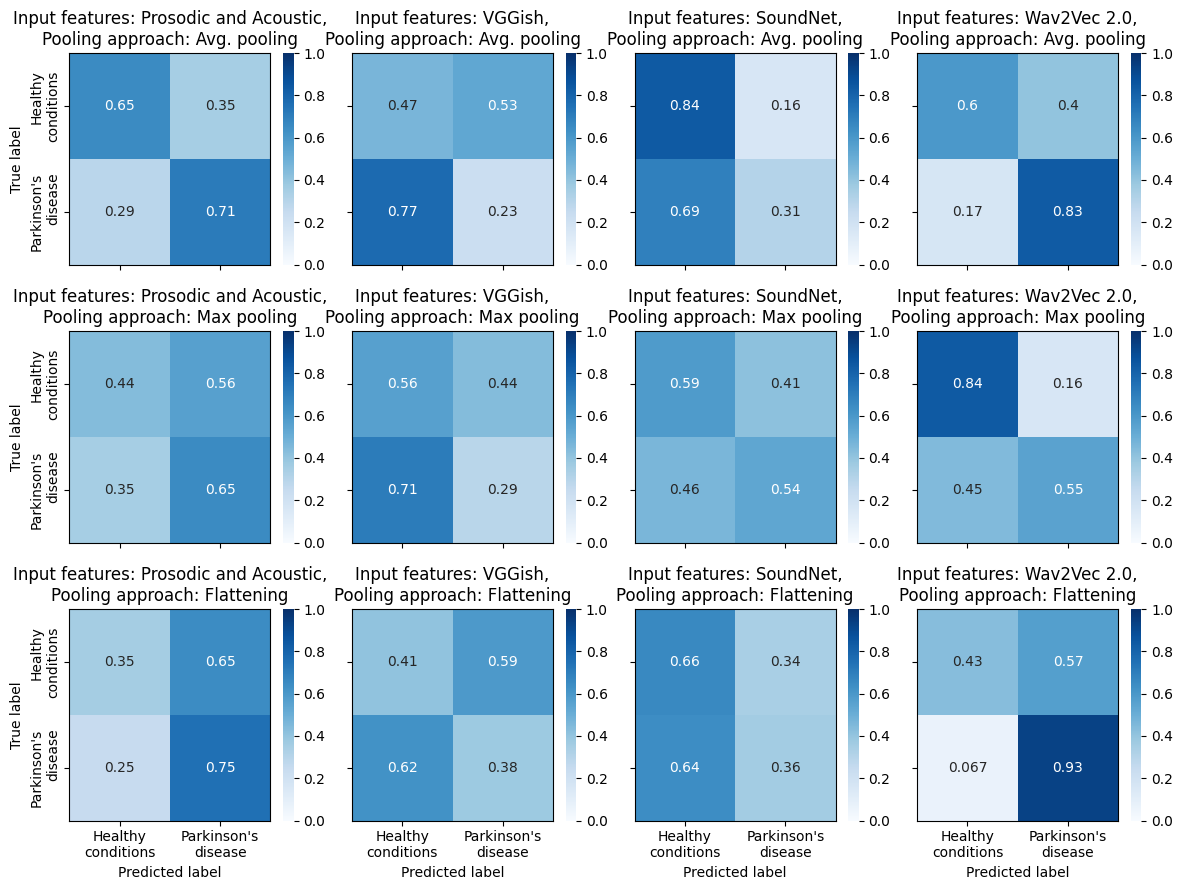

In [54]:
fig, axes = plt.subplots(
        nrows=len(df_no_ad['Pooling approach'].unique()),
        ncols=len(df_no_ad['Input features'].unique()),
        figsize=(12, 9),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        mat = np.array(df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'Confusion matrix')]['Value'].values[0]).astype(float)
        mat /= mat.sum(1).reshape(-1, 1)
        
        hmap = sns.heatmap(
            mat, 
            cmap=plt.colormaps['Blues'], 
            vmin=0.0, 
            vmax=1.0, 
            ax=axes[i][j], 
            annot=True, 
            linecolor='0', 
            xticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'], 
            yticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'],
        )
        sns.despine(ax=axes[i][j], top=False, right=False, left=False, bottom=False)
        sns.despine(ax=hmap, top=False, right=False, left=False, bottom=False)
        # fig.colorbar(mappable=mat, ax=axes[i][j])
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Predicted label')
        if j == 0:
            axes[i][j].set_ylabel('True label')
plt.tight_layout()
plt.show()

In [55]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_to_te_no_adpt_cm.pdf'))

### Detection in Hindi

In [56]:
df = df_te_to_en[
    (df_te_to_en['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_te_to_en['Data set'] == DATA_MAPPING['src']) & df_te_to_en['Metric'].isin(METRICS)]
# print(df)

#### Metrics comparison

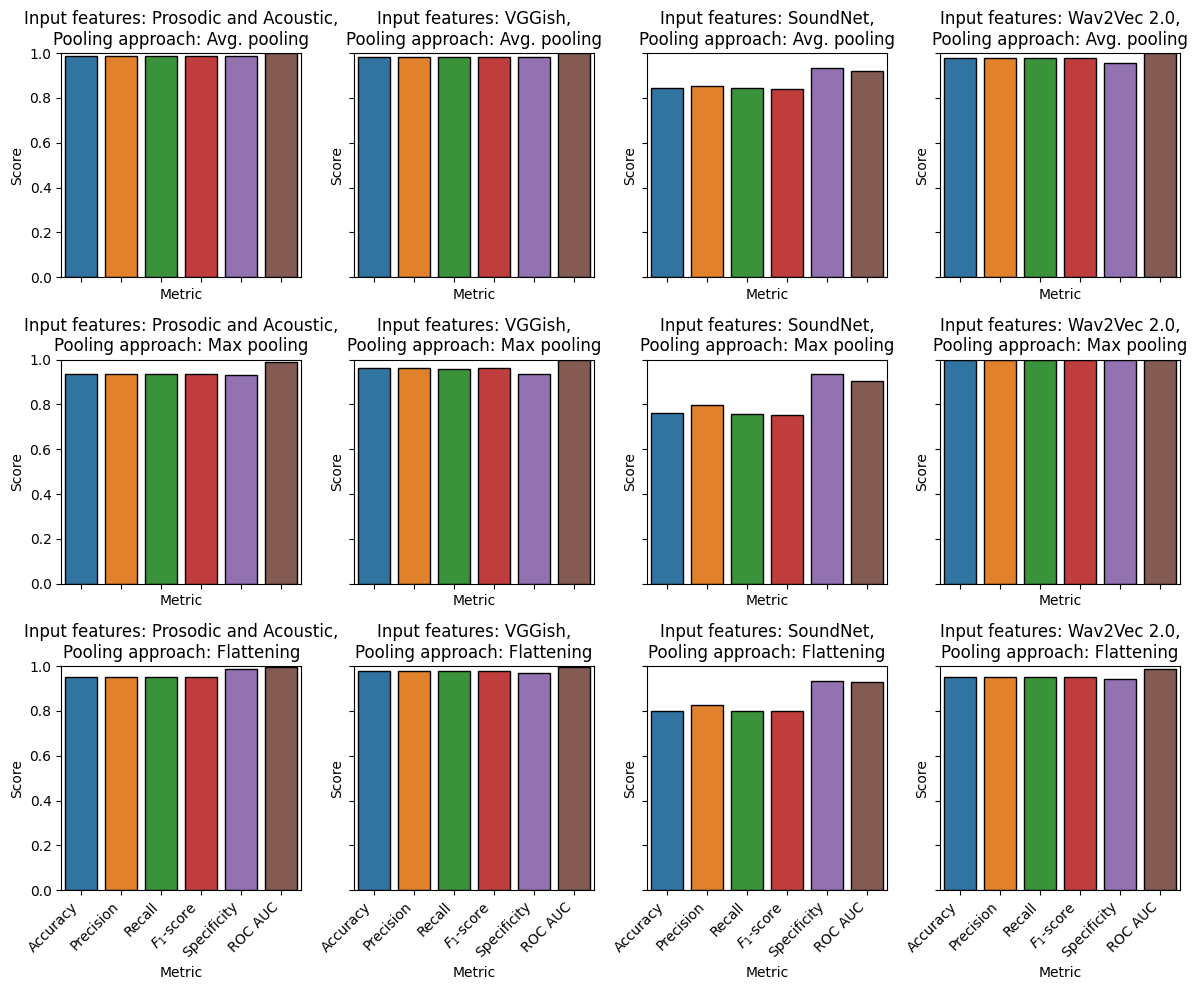

In [57]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        sns.barplot(
            data=df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling)],
            x='Metric',
            y='Value',
            ax=axes[i][j],
            linewidth=1.,
            edgecolor='0',
            order=list(METRICS)
        )
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        axes[i][j].set_xlabel('Metric')
        axes[i][j].set_ylabel('Score')
        axes[i][j].set_ylim(0.0, 1.0)
        # axes[i][j].grid()
        axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [58]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'te_cls_results.pdf'))

#### ROC curve

In [59]:
df = df_te_to_en[
    (df_te_to_en['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_te_to_en['Data set'] == DATA_MAPPING['src']) & (df_te_to_en['Metric'].isin(ROC))
]
df.sample(10)

,Input features,Pooling approach,Domain adaptation,Data set,Metric,Value
176,VGGish,Avg. pooling,None,Source data (test split),True postives rate,"[0.0, 0.014705882352941176, 0.9264705882352942..."
511,Wav2Vec 2.0,Avg. pooling,None,Source data (test split),False positives rate,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.5633802816901409, ..."
569,Wav2Vec 2.0,Max pooling,None,Source data (test split),Threshold (from ROC curve),"[2.0, 0.9999999403953552, 0.9999995827674866, ..."
119,Prosodic and Acoustic,Flattening,None,Source data (test split),False positives rate,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0140845070422..."
288,VGGish,Flattening,None,Source data (test split),True postives rate,"[0.0, 0.014705882352941176, 0.0441176470588235..."
232,VGGish,Max pooling,None,Source data (test split),True postives rate,"[0.0, 0.014705882352941176, 0.8382352941176471..."
287,VGGish,Flattening,None,Source data (test split),False positives rate,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.016129032258064516..."
457,SoundNet,Flattening,None,Source data (test split),Threshold (from ROC curve),"[1.9999994039535522, 0.9999994039535522, 0.770..."
625,Wav2Vec 2.0,Flattening,None,Source data (test split),Threshold (from ROC curve),"[2.0, 1.0, 0.9672501087188721, 0.9636921882629..."
623,Wav2Vec 2.0,Flattening,None,Source data (test split),False positives rate,"[0.0, 0.0, 0.0, 0.014084507042253521, 0.014084..."


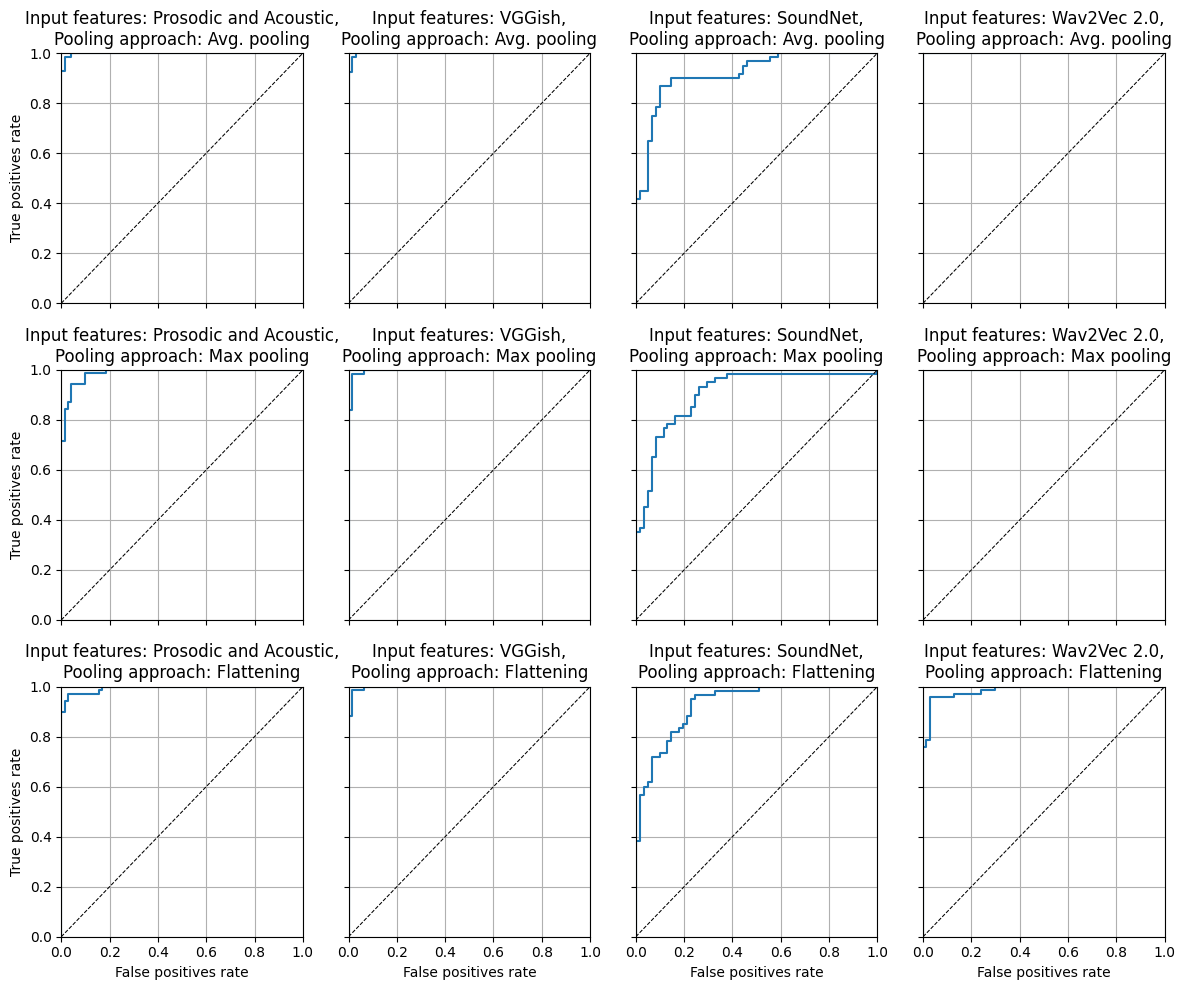

In [60]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        x = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'False positives rate')]['Value'].values[0]
        y = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'True postives rate')]['Value'].values[0]
        axes[i][j].plot(x, y)
        axes[i][j].plot([0, 1], [0, 1], '--k', linewidth=0.75)
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('False positives rate')
        if j == 0:
            axes[i][j].set_ylabel('True positives rate')
        axes[i][j].set_xlim(0.0, 1.0)
        axes[i][j].set_ylim(0.0, 1.0)
        axes[i][j].grid()
        # axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [61]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'te_roc_curve.pdf'))

#### Precision-recall curve

In [62]:
df = df_te_to_en[
    (df_te_to_en['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_te_to_en['Data set'] == DATA_MAPPING['src']) & (df_te_to_en['Metric'].isin(PRC_REC))
]
df.sample(10)

,Input features,Pooling approach,Domain adaptation,Data set,Metric,Value
404,SoundNet,Max pooling,None,Source data (test split),Threshold (from precision-recall curve),"[0.002096745651215315, 0.010358424857258797, 0..."
178,VGGish,Avg. pooling,None,Source data (test split),Precision score,"[0.5230769230769231, 0.5271317829457365, 0.531..."
179,VGGish,Avg. pooling,None,Source data (test split),Recall score,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
572,Wav2Vec 2.0,Max pooling,None,Source data (test split),Threshold (from precision-recall curve),"[1.201585636545488e-10, 2.362843531944492e-10,..."
346,SoundNet,Avg. pooling,None,Source data (test split),Precision score,"[0.49586776859504134, 0.5, 0.5042016806722689,..."
570,Wav2Vec 2.0,Max pooling,None,Source data (test split),Precision score,"[0.49645390070921985, 0.5, 0.5035971223021583,..."
460,SoundNet,Flattening,None,Source data (test split),Threshold (from precision-recall curve),"[0.007538332138210535, 0.008218122646212578, 0..."
68,Prosodic and Acoustic,Max pooling,None,Source data (test split),Threshold (from precision-recall curve),"[1.1215801724862029e-11, 5.879372683148532e-11..."
122,Prosodic and Acoustic,Flattening,None,Source data (test split),Precision score,"[0.49645390070921985, 0.5, 0.5035971223021583,..."
291,VGGish,Flattening,None,Source data (test split),Recall score,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


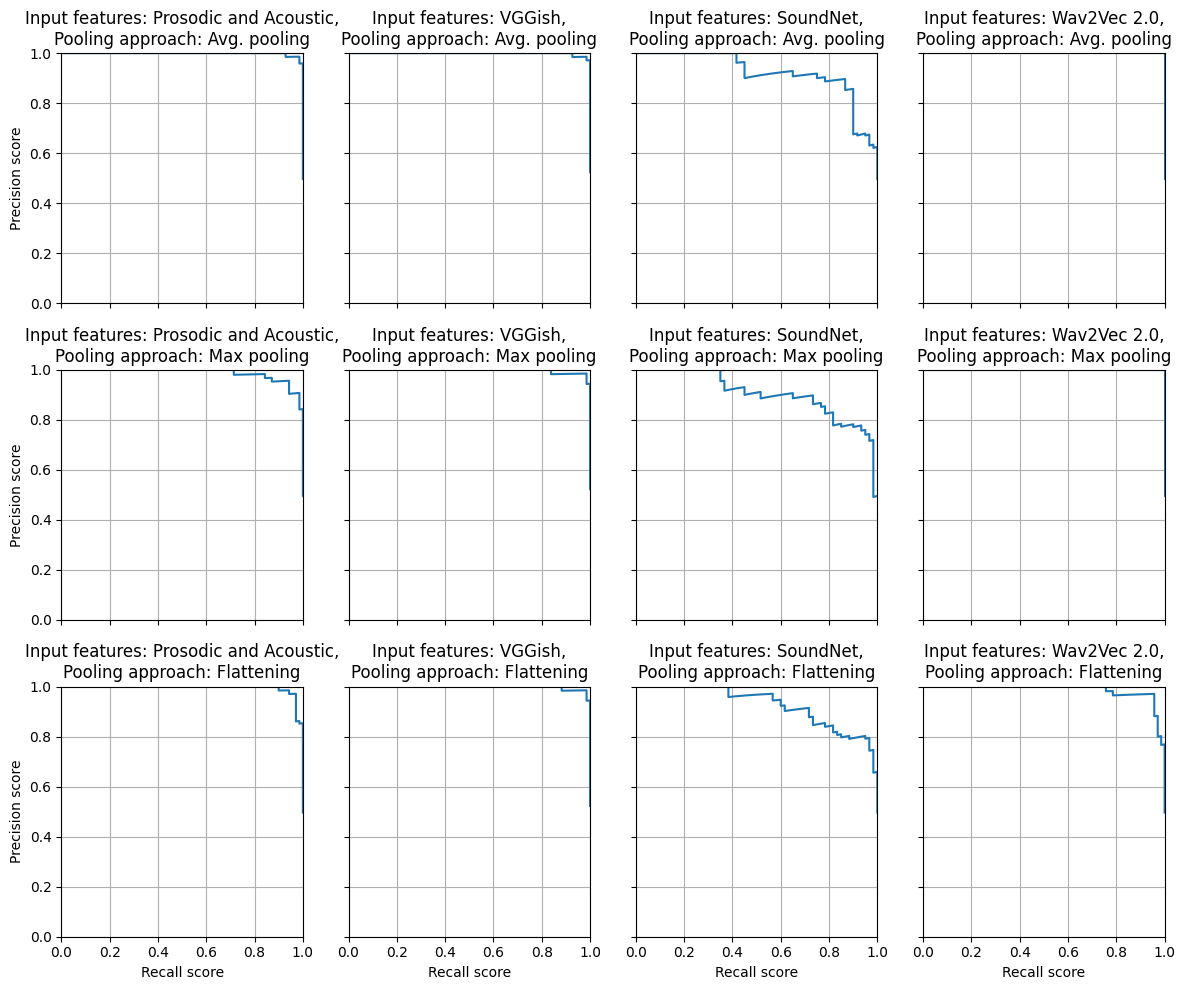

In [63]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        x = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Recall score')]['Value'].values[0]
        y = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Precision score')]['Value'].values[0]
        axes[i][j].plot(x, y)
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Recall score')
        if j == 0:
            axes[i][j].set_ylabel('Precision score')
        axes[i][j].set_xlim(0.0, 1.0)
        axes[i][j].set_ylim(0.0, 1.0)
        axes[i][j].grid()
        # axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [64]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'te_pr_curve.pdf'))

#### Confusion matrix

In [65]:
df = df_te_to_en[
    (df_te_to_en['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_te_to_en['Data set'] == DATA_MAPPING['src']) & (df_te_to_en['Metric'].isin(CONF_MAT))
]
df.sample(10)

,Input features,Pooling approach,Domain adaptation,Data set,Metric,Value
69,Prosodic and Acoustic,Max pooling,None,Source data (test split),Confusion matrix,"[[66, 5], [4, 66]]"
237,VGGish,Max pooling,None,Source data (test split),Confusion matrix,"[[58, 4], [1, 67]]"
181,VGGish,Avg. pooling,None,Source data (test split),Confusion matrix,"[[61, 1], [1, 67]]"
517,Wav2Vec 2.0,Avg. pooling,None,Source data (test split),Confusion matrix,"[[68, 3], [0, 70]]"
349,SoundNet,Avg. pooling,None,Source data (test split),Confusion matrix,"[[57, 4], [15, 45]]"
573,Wav2Vec 2.0,Max pooling,None,Source data (test split),Confusion matrix,"[[71, 0], [0, 70]]"
13,Prosodic and Acoustic,Avg. pooling,None,Source data (test split),Confusion matrix,"[[70, 1], [1, 69]]"
405,SoundNet,Max pooling,None,Source data (test split),Confusion matrix,"[[57, 4], [25, 35]]"
461,SoundNet,Flattening,None,Source data (test split),Confusion matrix,"[[57, 4], [20, 40]]"
125,Prosodic and Acoustic,Flattening,None,Source data (test split),Confusion matrix,"[[70, 1], [6, 64]]"


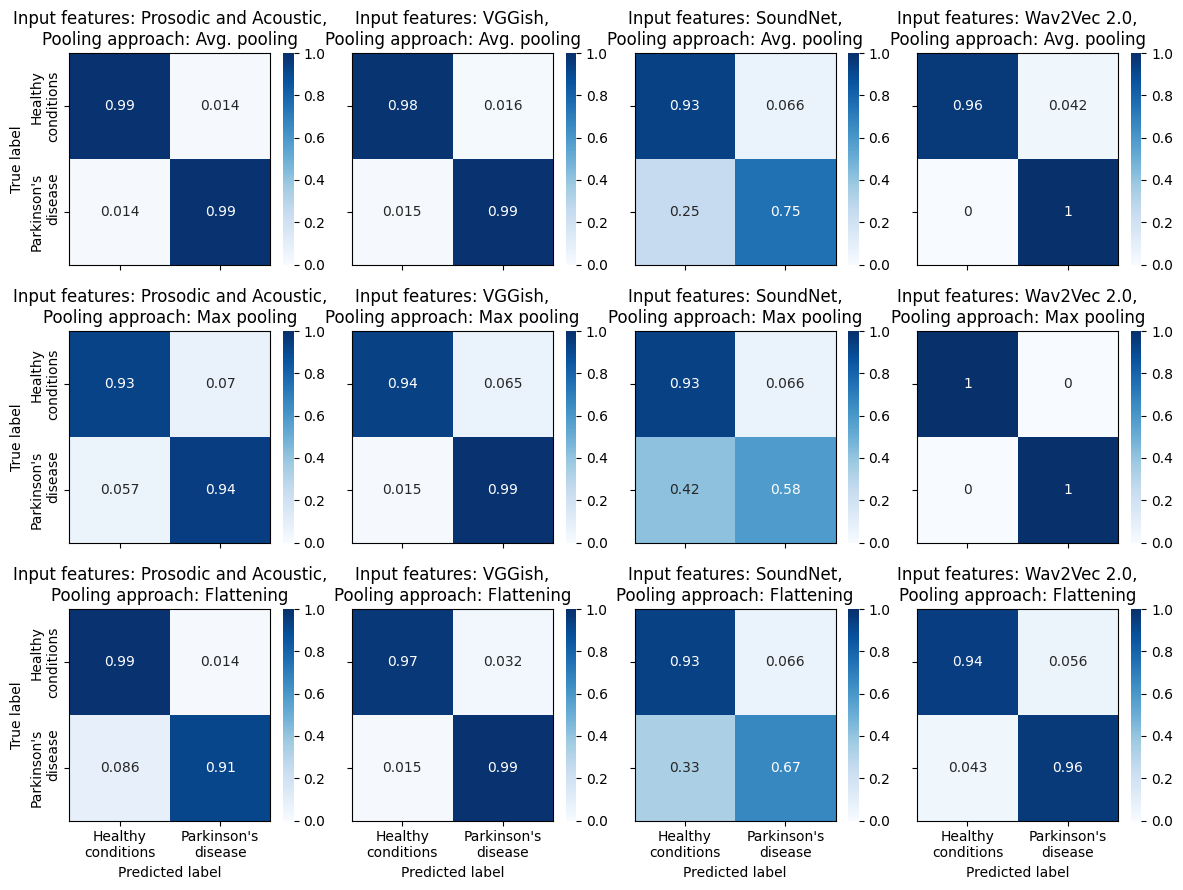

In [66]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 9),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        mat = np.array(df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Confusion matrix')]['Value'].values[0]).astype(float)
        mat /= mat.sum(1).reshape(-1, 1)
        
        hmap = sns.heatmap(
            mat, 
            cmap=plt.colormaps['Blues'], 
            vmin=0.0, 
            vmax=1.0, 
            ax=axes[i][j], 
            annot=True, 
            linecolor='0', 
            xticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'], 
            yticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'],
        )
        sns.despine(ax=axes[i][j], top=False, right=False, left=False, bottom=False)
        sns.despine(ax=hmap, top=False, right=False, left=False, bottom=False)
        # fig.colorbar(mappable=mat, ax=axes[i][j])
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Predicted label')
        if j == 0:
            axes[i][j].set_ylabel('True label')
plt.tight_layout()
plt.show()

In [67]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'te_cm.pdf'))

## Transferring from Hindi to English

In [68]:
df_all = df_te_to_en[
    (df_te_to_en['Data set'] == DATA_MAPPING['tgt']) & (df_te_to_en['Metric'].isin(METRICS))]
# print(df_all)

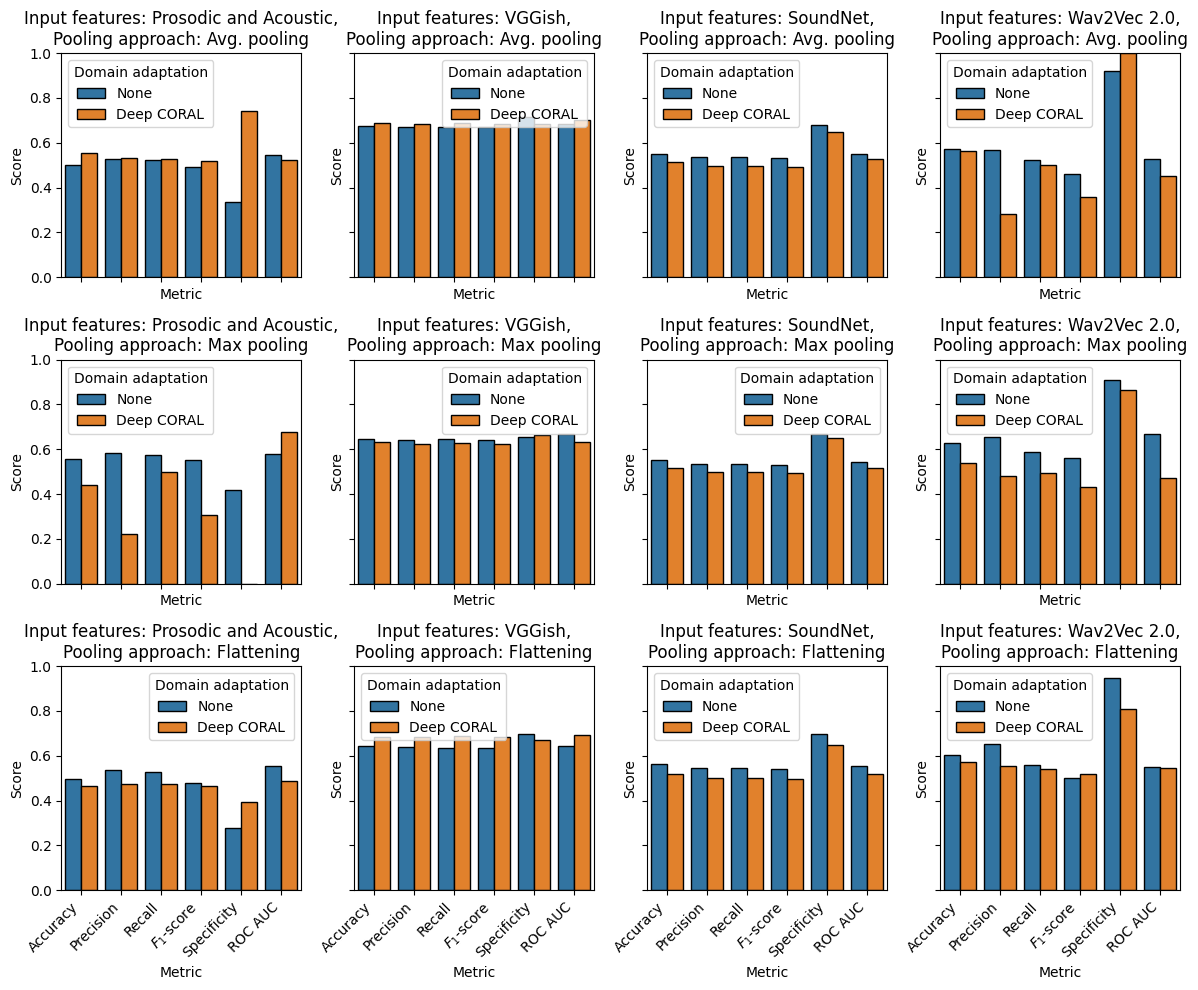

In [69]:
fig, axes = plt.subplots(
        nrows=len(df_all['Pooling approach'].unique()),
        ncols=len(df_all['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )



for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        
        sns.barplot(
            data=df_all[(df_all['Input features'] == feature) & (df_all['Pooling approach'] == pooling)],
            x='Metric',
            y='Value',
            ax=axes[i][j],
            linewidth=1.,
            edgecolor='0',
            order=list(METRICS),
            hue='Domain adaptation'
        )
       
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        axes[i][j].set_xlabel('Metric')
        axes[i][j].set_ylabel('Score')
        axes[i][j].set_ylim(0.0, 1.0)
        # axes[i][j].grid()
        axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [70]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'te_to_en_results.pdf'))

### ROC Curve

In [71]:
df = df_te_to_en[
    (df_te_to_en['Domain adaptation'] == ADAPTATION_MAPPING[True]) & (df_te_to_en['Data set'] == DATA_MAPPING['tgt']) & df_te_to_en['Metric'].isin(ROC)]
df_no_ad = df_te_to_en[
    (df_te_to_en['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_te_to_en['Data set'] == DATA_MAPPING['tgt']) & df_te_to_en['Metric'].isin(ROC)]


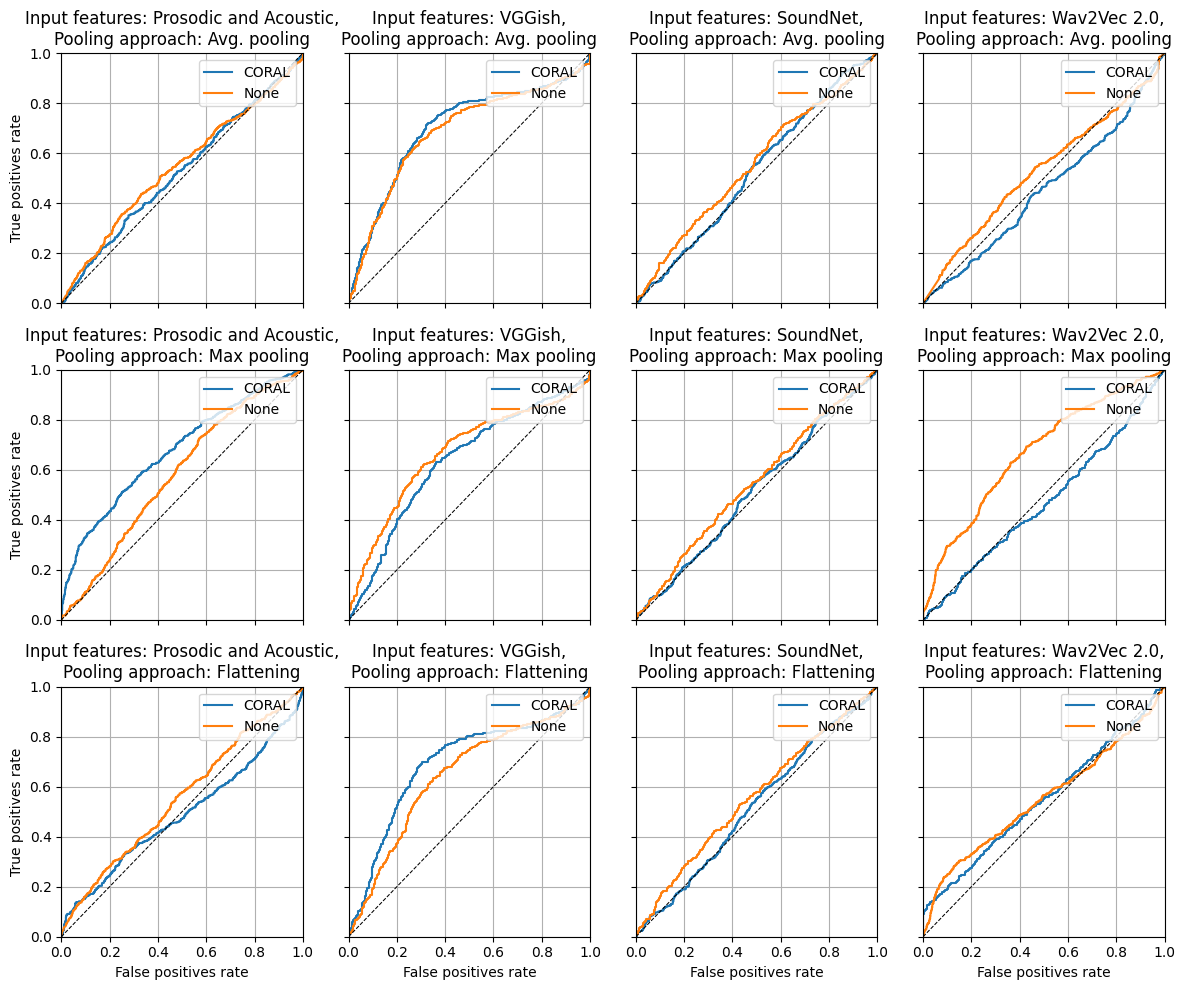

In [72]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        x = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'False positives rate')]['Value'].values[0]
        y = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'True postives rate')]['Value'].values[0]
        
        x_1 =  df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'False positives rate')]['Value'].values[0]
        y_1 =  df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'True postives rate')]['Value'].values[0]
        
        axes[i][j].plot(x, y, label='CORAL')
        axes[i][j].plot(x_1, y_1, label='None')
        axes[i][j].legend(loc='upper right')
        axes[i][j].plot([0, 1], [0, 1], '--k', linewidth=0.75)
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('False positives rate')
        if j == 0:
            axes[i][j].set_ylabel('True positives rate')
        axes[i][j].set_xlim(0.0, 1.0)
        axes[i][j].set_ylim(0.0, 1.0)
        axes[i][j].grid()

        # axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [73]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'te_to_en_roc_curve.pdf'))

### Precision-recall curve

In [74]:
df = df_te_to_en[
    (df_te_to_en['Domain adaptation'] == ADAPTATION_MAPPING[True]) & (df_te_to_en['Data set'] == DATA_MAPPING['tgt']) & df_te_to_en['Metric'].isin(PRC_REC)]
df_no_ad = df_te_to_en[
     (df_te_to_en['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_te_to_en['Data set'] == DATA_MAPPING['tgt']) & df_te_to_en['Metric'].isin(PRC_REC)]


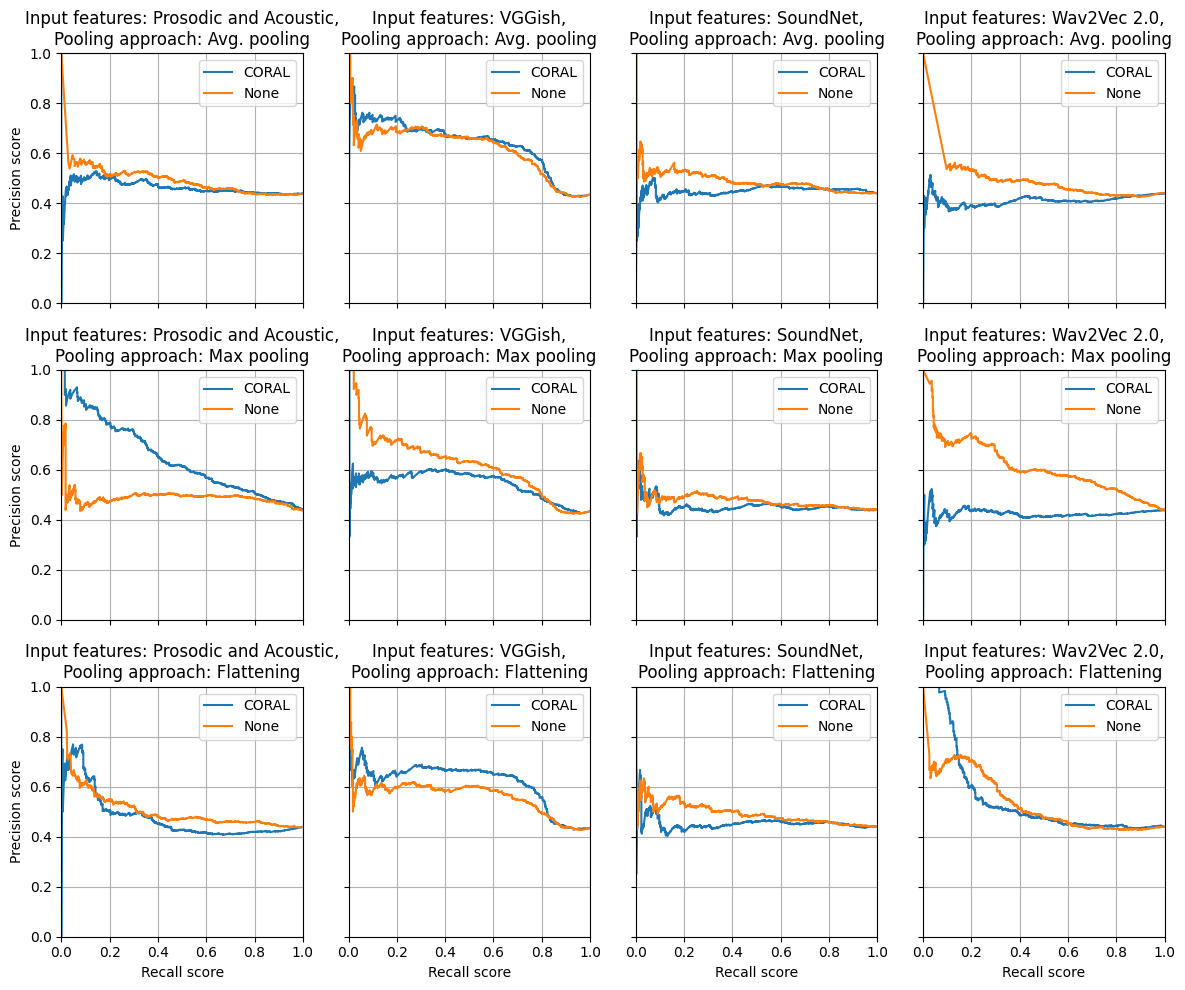

In [75]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        x = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Recall score')]['Value'].values[0]
        y = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Precision score')]['Value'].values[0]
        
        x_1 =  df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'Recall score')]['Value'].values[0]
        y_1 =  df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'Precision score')]['Value'].values[0]
        
        axes[i][j].plot(x, y, label='CORAL')
        axes[i][j].plot(x_1, y_1, label='None')
        axes[i][j].legend(loc='upper right')
        # axes[i][j].plot([0, 1], [0, 1], '--k', linewidth=0.75)
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Recall score')
        if j == 0:
            axes[i][j].set_ylabel('Precision score')
        axes[i][j].set_xlim(0.0, 1.0)
        axes[i][j].set_ylim(0.0, 1.0)
        axes[i][j].grid()

        # axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [76]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'te_to_en_pr_curve.pdf'))

### Confusion matrix

In [77]:
df = df_te_to_en[
    (df_te_to_en['Domain adaptation'] == ADAPTATION_MAPPING[True]) & (df_te_to_en['Data set'] == DATA_MAPPING['tgt']) & df_te_to_en['Metric'].isin(CONF_MAT)]
df_no_ad = df_te_to_en[
     (df_te_to_en['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_te_to_en['Data set'] == DATA_MAPPING['tgt']) & df_te_to_en['Metric'].isin(CONF_MAT)]


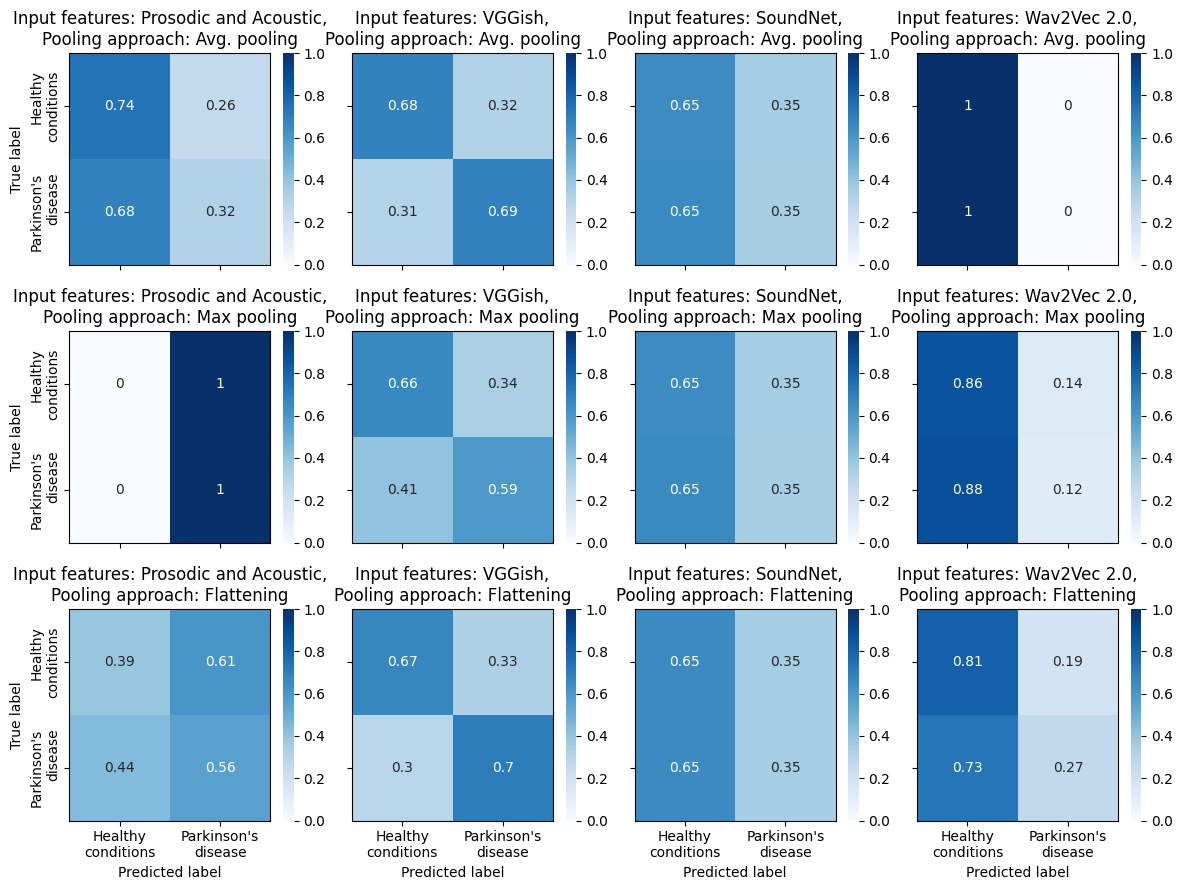

In [78]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 9),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        mat = np.array(df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Confusion matrix')]['Value'].values[0]).astype(float)
        mat /= mat.sum(1).reshape(-1, 1)
        
        hmap = sns.heatmap(
            mat, 
            cmap=plt.colormaps['Blues'], 
            vmin=0.0, 
            vmax=1.0, 
            ax=axes[i][j], 
            annot=True, 
            linecolor='0', 
            xticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'], 
            yticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'],
        )
        sns.despine(ax=axes[i][j], top=False, right=False, left=False, bottom=False)
        sns.despine(ax=hmap, top=False, right=False, left=False, bottom=False)
        # fig.colorbar(mappable=mat, ax=axes[i][j])
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Predicted label')
        if j == 0:
            axes[i][j].set_ylabel('True label')
plt.tight_layout()
plt.show()

In [79]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'te_to_en_with_adpt_cm.pdf'))

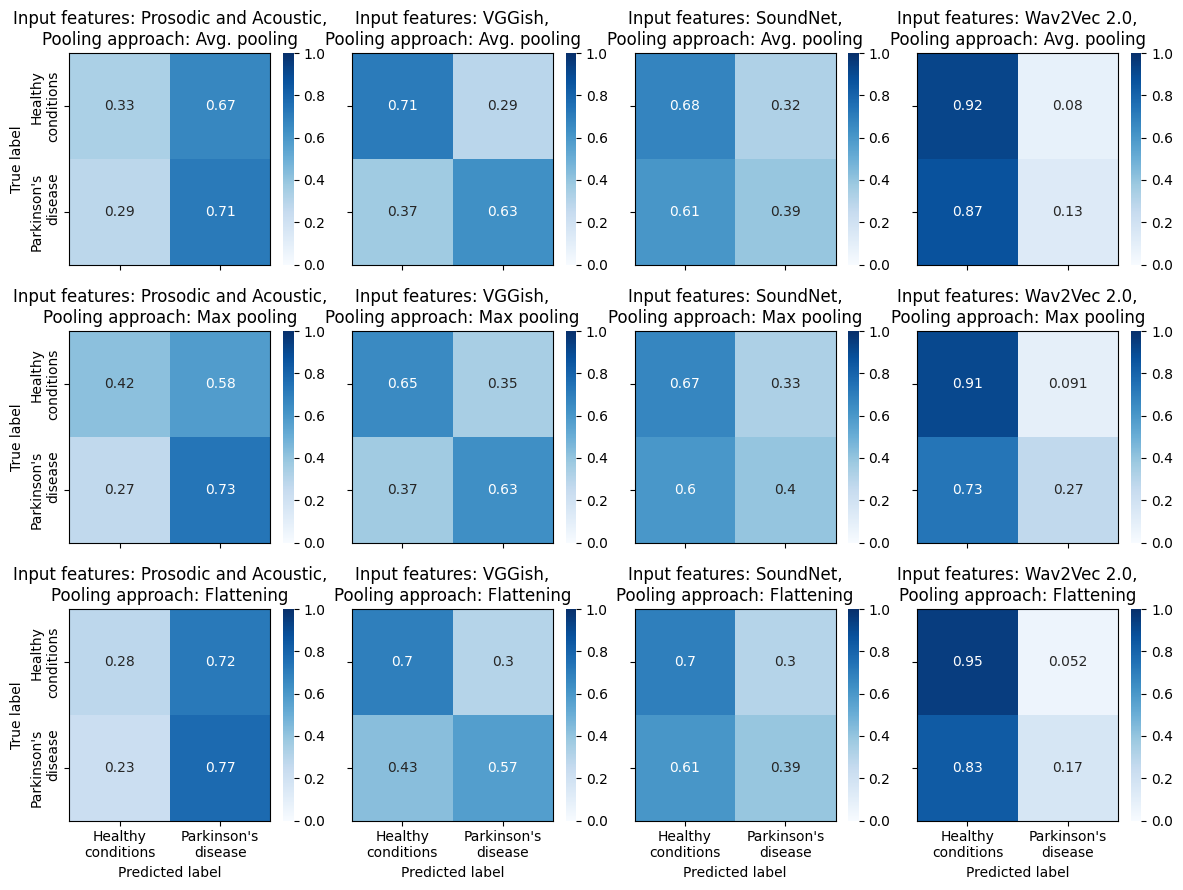

In [80]:
fig, axes = plt.subplots(
        nrows=len(df_no_ad['Pooling approach'].unique()),
        ncols=len(df_no_ad['Input features'].unique()),
        figsize=(12, 9),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        mat = np.array(df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'Confusion matrix')]['Value'].values[0]).astype(float)
        mat /= mat.sum(1).reshape(-1, 1)
        
        hmap = sns.heatmap(
            mat, 
            cmap=plt.colormaps['Blues'], 
            vmin=0.0, 
            vmax=1.0, 
            ax=axes[i][j], 
            annot=True, 
            linecolor='0', 
            xticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'], 
            yticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'],
        )
        sns.despine(ax=axes[i][j], top=False, right=False, left=False, bottom=False)
        sns.despine(ax=hmap, top=False, right=False, left=False, bottom=False)
        # fig.colorbar(mappable=mat, ax=axes[i][j])
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Predicted label')
        if j == 0:
            axes[i][j].set_ylabel('True label')
plt.tight_layout()
plt.show()

In [81]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'te_to_en_no_adpt_cm.pdf'))